<div style="text-align: right">INFO 6106 Neural Modeling, Final Project, Milestone 2</div>
<div style="text-align: right">Lokeshwaran Balamurugan, Nitin Sai Varma Indukuri, Krishica Gopalakrishnan</div>

# Data Prepration for Inference

This notebook serves as a crucial preprocessing step in our hybrid meteorological and satellite image forecasting project. Its primary purpose is to prepare and structure our complex dataset, combining time-series meteorological data with satellite imagery, for efficient use in subsequent machine learning models.

We'll be performing several key tasks:
- Loading meteorological data and satellite images
- Aligning temporal data from both sources
- Creating sliding window sequences for time-series prediction
- Encoding categorical variables and normalizing numerical features
- Structuring the data into a format optimized for our hybrid models
- Saving the processed data in a readily loadable format

By completing these steps, we'll create a streamlined dataset that can be easily imported into our model training and inference notebooks. This separation of data preparation and model implementation not only improves code organization but also allows for more efficient experimentation with different model architectures and hyperparameters.

## 1. Importing Libraries

These libraries are essential for tasks involving data preprocessing, visualization, and model development. Libraries like os, pandas, and numpy facilitate loading, cleaning, and manipulating both meteorological time-series and satellite image data, while pickle helps save and reuse processed datasets or trained models. Image-specific tools like PIL and cv2 enable resizing, augmenting, and transforming satellite images for model input, and SMOTE addresses class imbalance in datasets. Visualization libraries, including matplotlib and seaborn, help track training progress and evaluate model performance using plots such as confusion matrices and learning curves. Lastly, utility libraries like tqdm enhance workflow efficiency with progress bars, and warnings ensures clean, readable outputs by suppressing unnecessary alerts.

In [1]:
# Data Manipulation Libraries
import os
import pandas as pd
import numpy as np
import pickle
import ast

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

# Image Processing Libraries
from PIL import Image, ImageOps
import cv2

from imblearn.over_sampling import SMOTE

# Utility Libraries
from tqdm import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Loading Data

We'll now preprocess and manage the datasets required for training hybrid models that combine meteorological and satellite image data. To achieve this, we start by defining different temporal window sizes such as 24, 48, and 72 hours, along with the corresponding number of satellite images and prediction shifts for each window size. These settings will allow us to experiment with varying input-output configurations.

In [2]:
# Define window sizes and corresponding number of images
window_sizes = [24, 48, 72]  # in hours
images_per_window_dict = {24: 8, 48: 16, 72: 24}

# Define the prediction shift for each window size
prediction_shifts = {24: 24, 48: 48, 72: 72}

# window_sizes = [24]  # in hours
# images_per_window_dict = {24: 8}

# # Define the prediction shift for each window size
# prediction_shifts = {24: 24}

# Define meteorological features to include
meteo_features = [
    'Temp_F', 'RH_pct', 'Dewpt_F', 'Wind_Spd_mph',
    'Wind_Direction_deg', 'Peak_Wind_Gust_mph',
    'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
    'High_Cloud_Ht_ft', 'Visibility_mi',
    'Atm_Press_hPa', 'Sea_Lev_Press_hPa',
    'Altimeter_hPa', 'Precip_in'
]

Next, we'll set up a directory to store all preprocessed data, ensuring that previously processed datasets can be reused. For each window size, we'll check if the required preprocessed files exist. If they do, we'll load them, including meteorological data, satellite image data, target variables, and timestamps. These timestamps will help us maintain the temporal sequence and alignment necessary for accurate modeling.

In [3]:
# Dictionary to store processed data
data_windows = {window_size: {'X_meteo': [], 'X_images': [], 'y': [], 'timestamps': []} for window_size in window_sizes}

In [4]:
import os
import pickle

# Directory to store preprocessed data
data_dir = "preprocessed_data_corrected_final"
os.makedirs(data_dir, exist_ok=True)

# Dictionary to hold filepaths for processed data, including timestamps
data_files = {
    window_size: {
        'X_meteo': os.path.join(data_dir, f"X_meteo_{window_size}.pkl"),
        'X_images': os.path.join(data_dir, f"X_images_{window_size}.pkl"),
        'y': os.path.join(data_dir, f"y_{window_size}.pkl"),
        'timestamps': os.path.join(data_dir, f"timestamps_{window_size}.pkl"),  # Add timestamps
    } for window_size in window_sizes
}


# Dictionary to store processed data
data_windows = {window_size: {'X_meteo': [], 'X_images': [], 'y': [], 'timestamps': []} for window_size in window_sizes}

for window_size in window_sizes:
    print(f"\nProcessing data for window size: {window_size} hours")
    
    # Prediction shift for the current window size
    prediction_shift = prediction_shifts[window_size]
    
    # Check if all files exist for this window size
    if all(os.path.exists(data_files[window_size][key]) for key in ['X_meteo', 'X_images', 'y']):
        print(f"Data exists for window size: {window_size}. Loading...")
        
        # Load preprocessed data
        with open(data_files[window_size]['X_meteo'], 'rb') as f:
            data_windows[window_size]['X_meteo'] = pickle.load(f)
        with open(data_files[window_size]['X_images'], 'rb') as f:
            data_windows[window_size]['X_images'] = pickle.load(f)
        with open(data_files[window_size]['y'], 'rb') as f:
            data_windows[window_size]['y'] = pickle.load(f)
        with open(data_files[window_size]['timestamps'], 'rb') as f:  # Load timestamps
            data_windows[window_size]['timestamps'] = pickle.load(f)
        
        print(f"Loaded data for window size {window_size}: "
              f"X_meteo shape {np.array(data_windows[window_size]['X_meteo']).shape}, "
              f"X_images shape {np.array(data_windows[window_size]['X_images']).shape}, "
              f"y shape {np.array(data_windows[window_size]['y']).shape}")
print("Processing complete.")


Processing data for window size: 24 hours
Data exists for window size: 24. Loading...
Loaded data for window size 24: X_meteo shape (47834, 24, 14), X_images shape (47834, 32768), y shape (47834,)

Processing data for window size: 48 hours
Data exists for window size: 48. Loading...
Loaded data for window size 48: X_meteo shape (47786, 48, 14), X_images shape (47786, 65536), y shape (47786,)

Processing data for window size: 72 hours
Data exists for window size: 72. Loading...
Loaded data for window size 72: X_meteo shape (47738, 72, 14), X_images shape (47738, 98304), y shape (47738,)
Processing complete.


Now that we have all the data loaded, let's look at a couple of our sliding window samples from the 72-Hour Window that we are going to use to train this model.

In [5]:
def display_sliding_window_samples(data_windows, window_size, num_samples=24):
    """
    Display sliding window samples including meteorological data, associated images with timestamps, and window timeframe.

    Args:
        data_windows (dict): Contains 'X_meteo', 'X_images', 'timestamps', and 'y' for each window size.
        window_size (int): Size of the sliding window (24, 48, or 72 hours).
        num_samples (int): Number of sliding window samples to display.
    """
    # Extract relevant data for the given window size
    X_meteo = np.array(data_windows[window_size]['X_meteo'])
    X_images = np.array(data_windows[window_size]['X_images']).reshape(-1, images_per_window_dict[window_size], 64, 64)
    y = np.array(data_windows[window_size]['y'])
    timestamps = np.array(data_windows[window_size]['timestamps'])

    # Feature column names for meteorological data
    meteo_columns = [
        'Temp_F', 'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
        'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
        'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
        'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'
    ]

    # Display the selected number of samples
    for i in range(min(num_samples, len(X_meteo))):
        print(f"Sample {i + 1} (Window Size: {window_size} hours)")
        print(f"Timeframe: {timestamps[i][0]} to {timestamps[i][-1]}")
        print("--------------------------------------------------")

        # Display meteorological data
        print("Meteorological Data:")
        display(pd.DataFrame(X_meteo[i], columns=meteo_columns))
        print(f"Target (y): {y[i]}")

        # Plot images with timestamps
        fig, axes = plt.subplots(1, X_images.shape[1], figsize=(20, 5))
        plt.suptitle(f"Images for Sample {i + 1} (Window {window_size} hours)")

        for j, (img, ts) in enumerate(zip(X_images[i], timestamps[i])):
            ax = axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(ts if ts != "No Image" else "Placeholder")

        plt.tight_layout()
        plt.show()

Sample 1 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,7.0,150.0,0.0,4100.0,4800.0,7000.0,10.0,984.0,1007.0,1006.8,0.00
1,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,983.7,1006.5,1006.4,0.00
2,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00
3,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00
4,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
5,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
6,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
7,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
8,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
9,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00


Target (y): 3


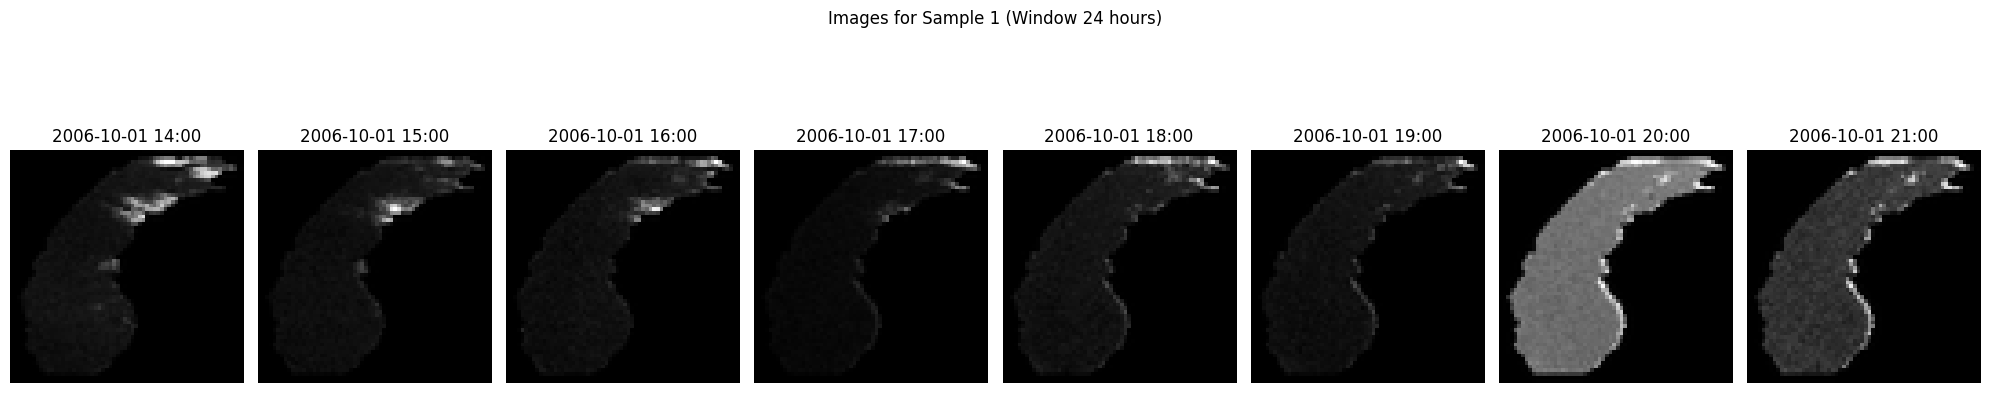

Sample 2 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,983.7,1006.5,1006.4,0.00
1,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00
2,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00
3,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
4,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
5,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
6,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
7,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
8,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
9,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00


Target (y): 3


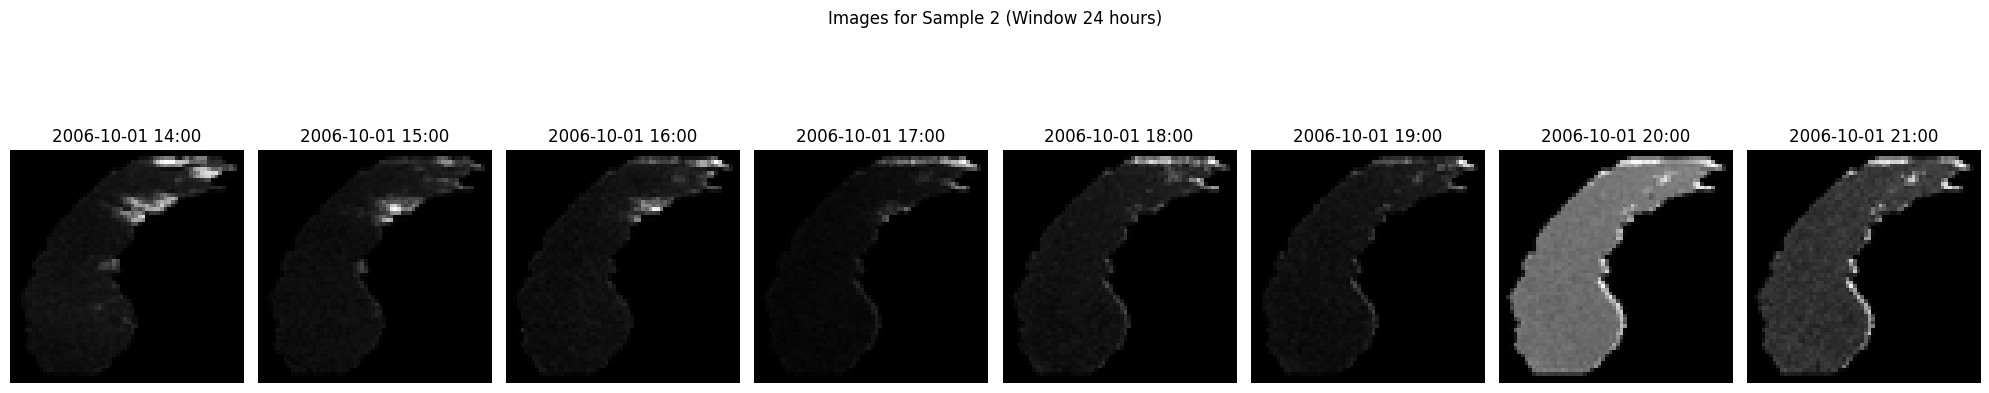

Sample 3 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00
1,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00
2,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
3,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
4,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
5,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
6,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
7,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
8,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
9,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00


Target (y): 3


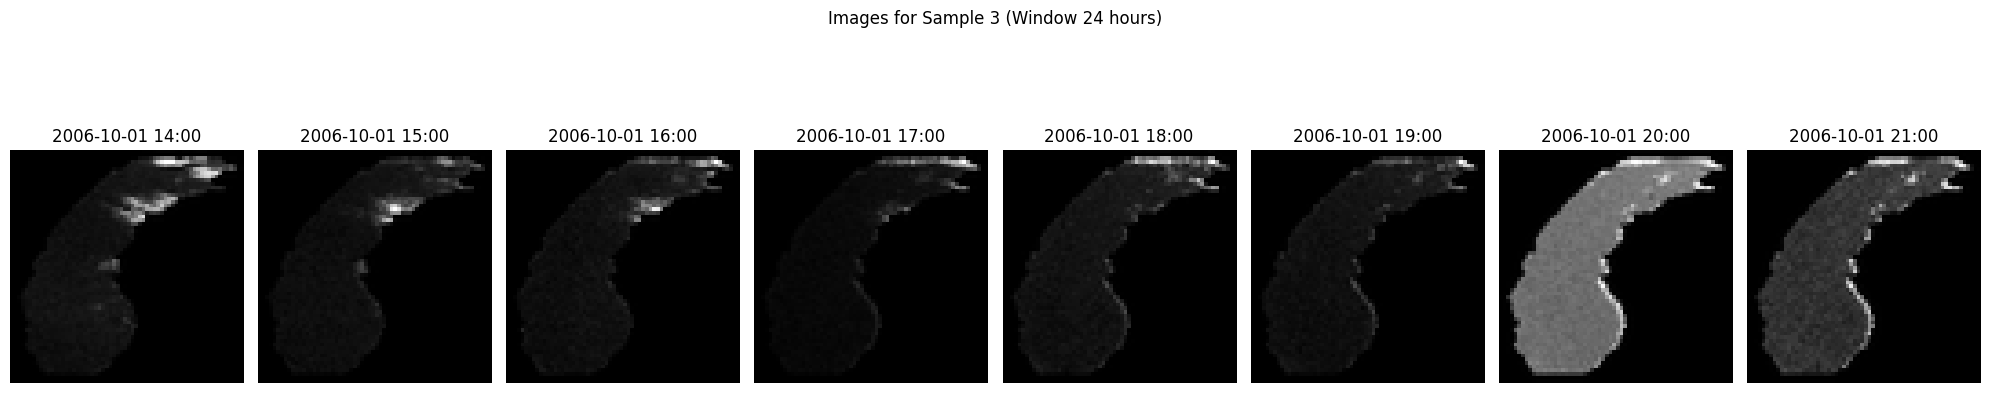

Sample 4 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00
1,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
2,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
3,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
4,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
5,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
6,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
7,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
8,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
9,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00


Target (y): 3


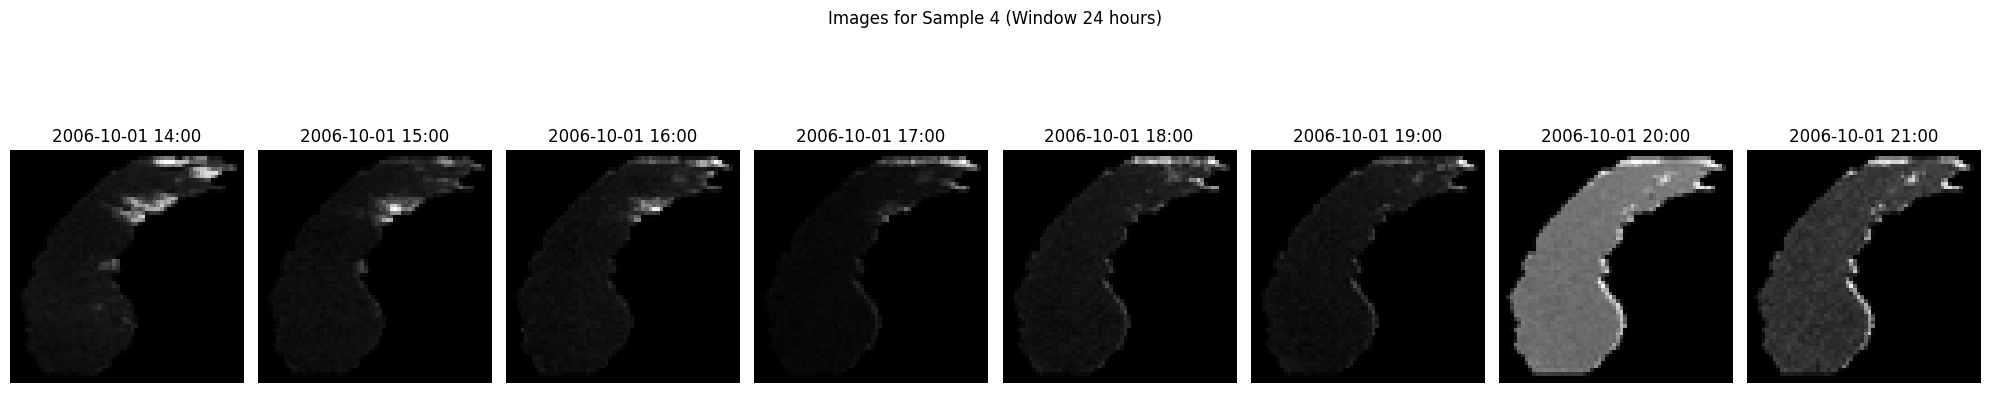

Sample 5 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02
1,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
2,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
3,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
4,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
5,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
6,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
7,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
8,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
9,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00


Target (y): 1


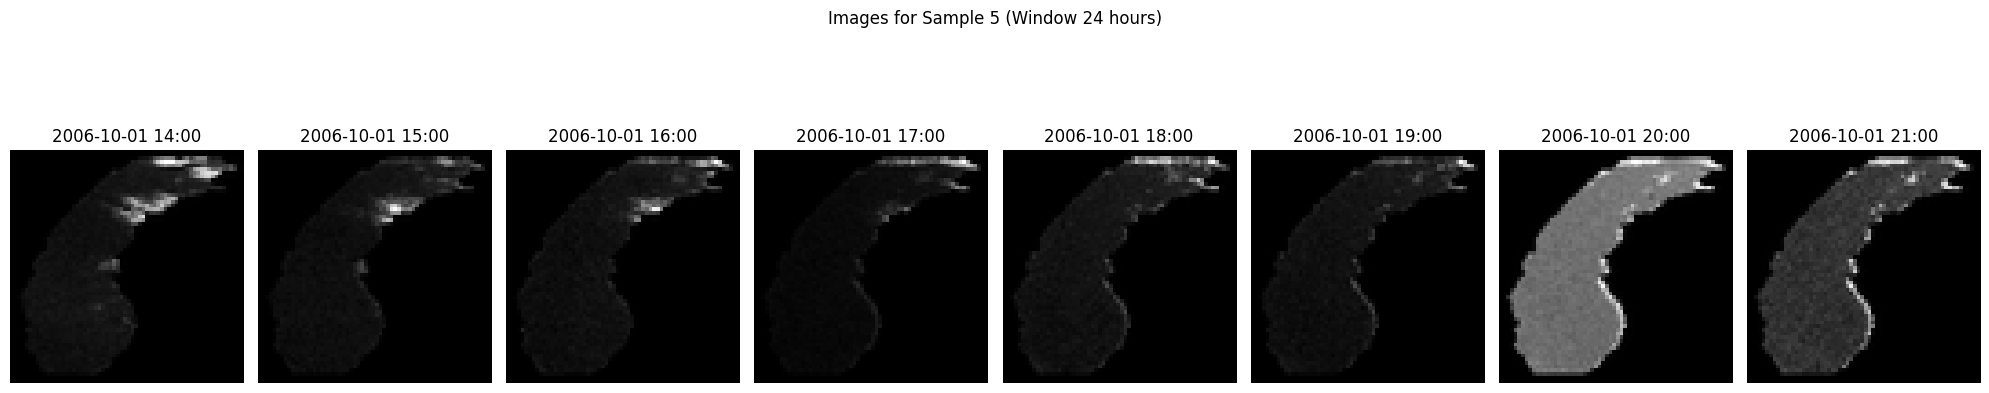

Sample 6 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,89.0,45.0,6.0,0.0,0.0,2700.0,5500.0,7500.0,10.0,981.7,1004.6,1004.4,0.01
1,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
2,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
3,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
4,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
5,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
6,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
7,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
8,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
9,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00


Target (y): 3


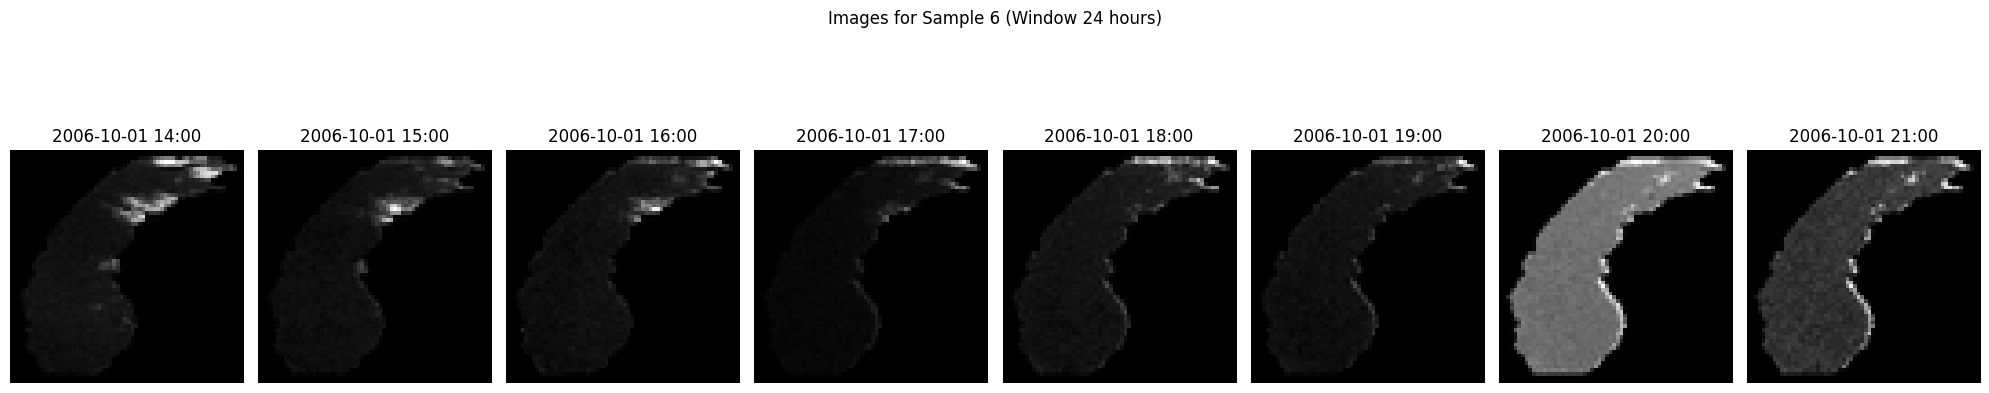

Sample 7 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,42.0,95.0,41.0,0.0,0.0,0.0,4600.0,0.0,0.0,8.0,991.7,1014.8,1014.6,0.00
1,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
2,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
3,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
4,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
5,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
6,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
7,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
8,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
9,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00


Target (y): 3


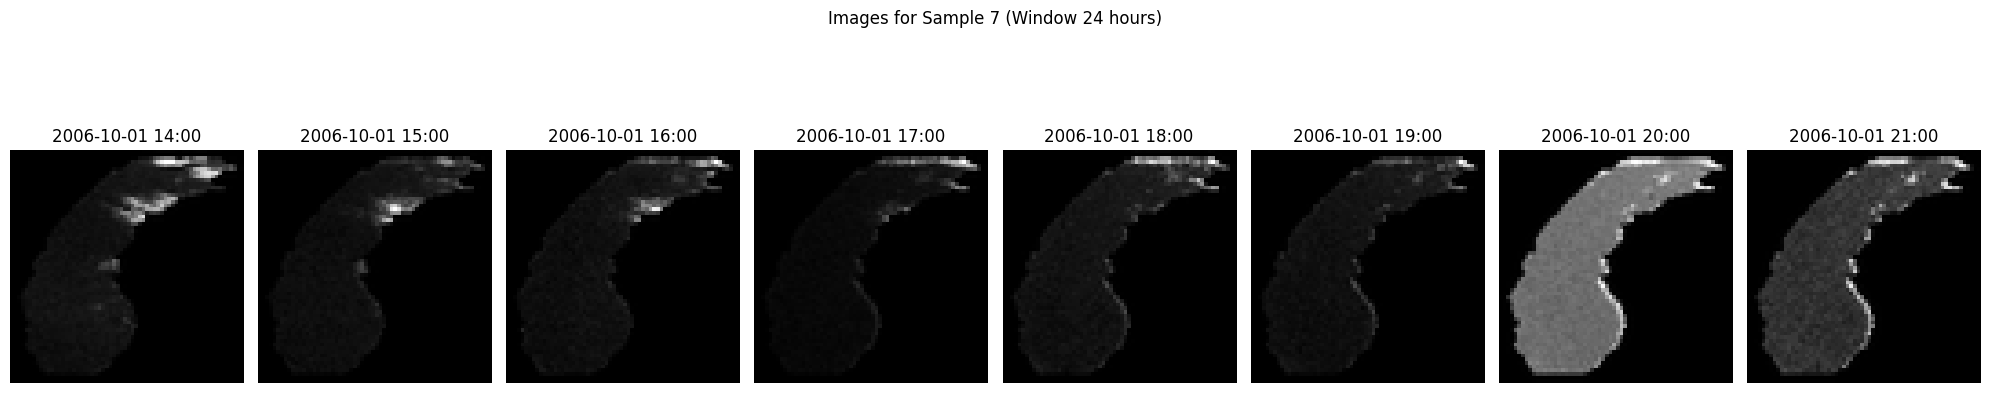

Sample 8 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,43.0,96.0,42.0,0.0,0.0,0.0,3900.0,0.0,0.0,10.0,992.3,1015.6,1015.2,0.00
1,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
2,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
3,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
4,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
5,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
6,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
7,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
8,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
9,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00


Target (y): 3


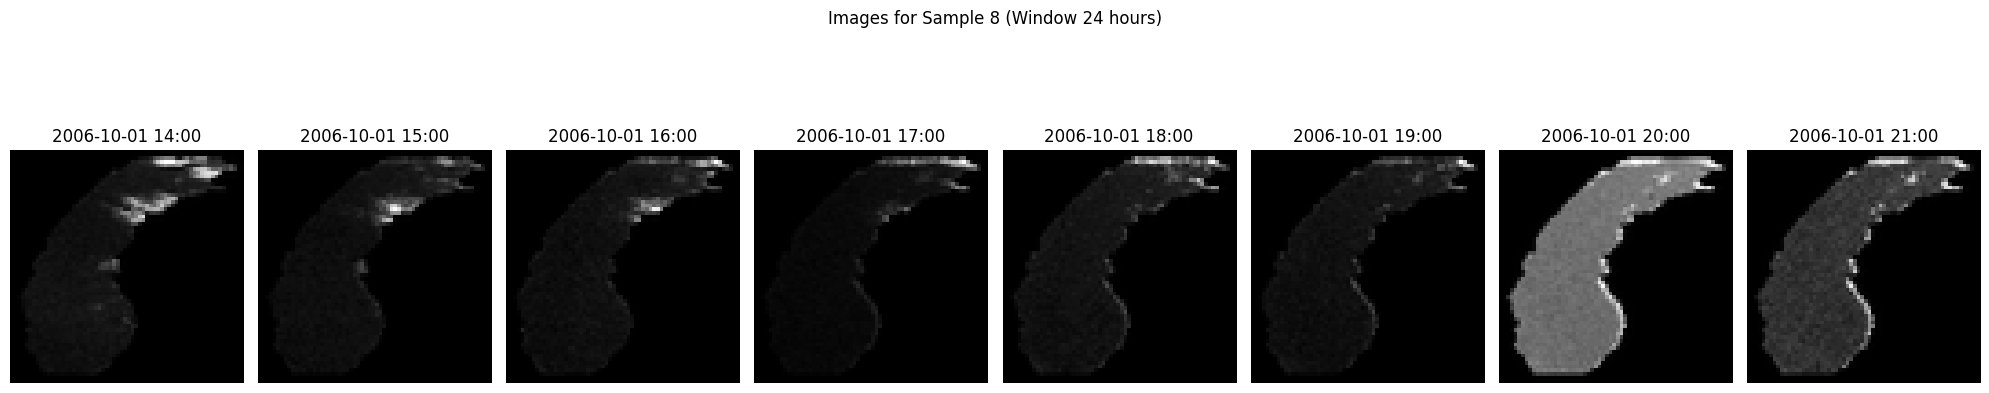

Sample 9 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,92.0,46.0,0.0,0.0,0.0,3600.0,0.0,0.0,10.0,993.0,1016.3,1015.9,0.00
1,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
2,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
3,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
4,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
5,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
6,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
7,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
8,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
9,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00


Target (y): 3


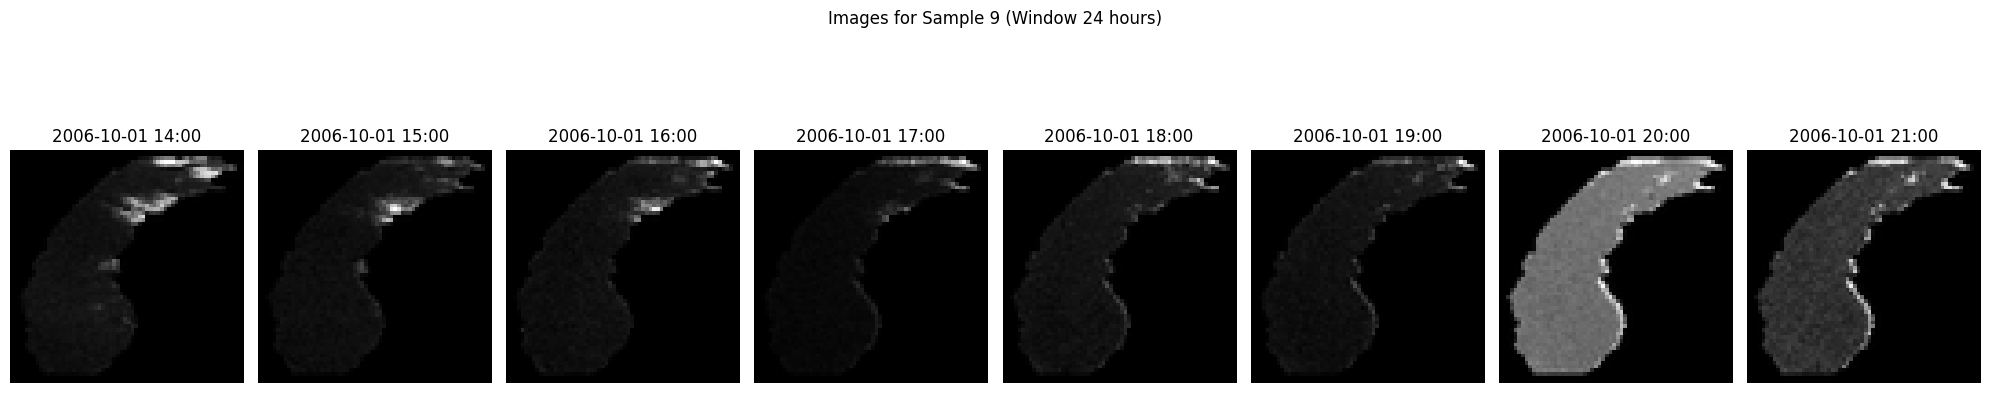

Sample 10 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,55.0,59.0,41.0,11.0,300.0,0.0,3600.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
1,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
2,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
3,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
4,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
5,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
6,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
7,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
8,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
9,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00


Target (y): 3


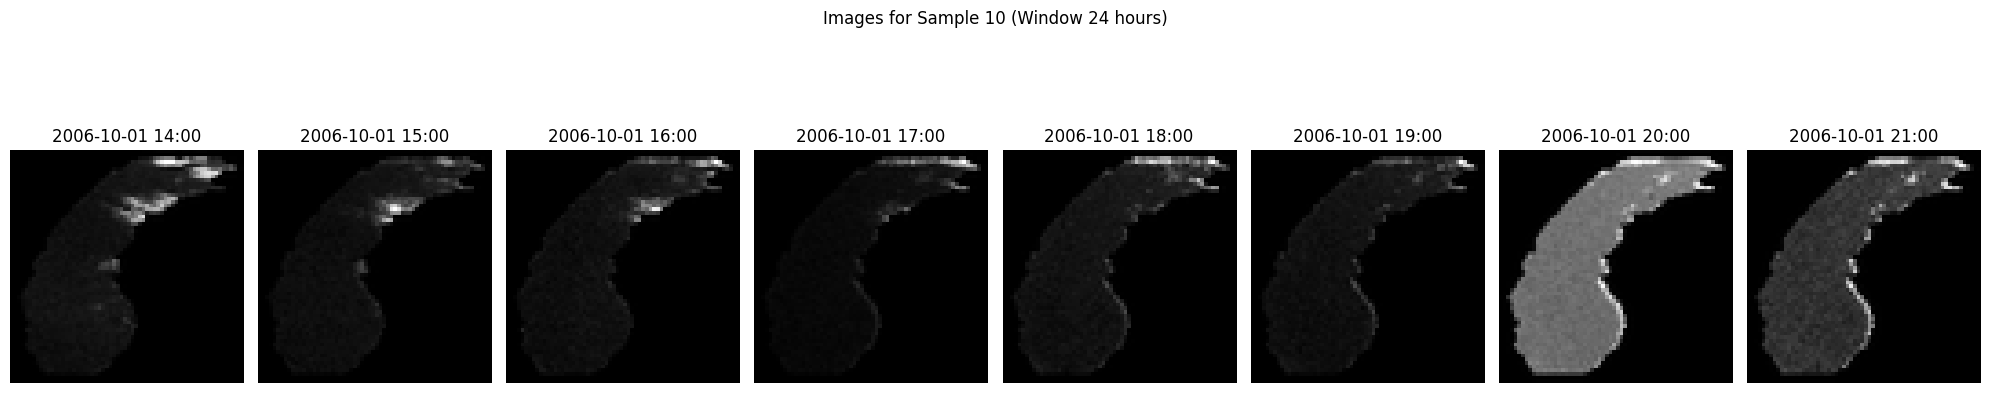

Sample 11 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,55.0,61.0,42.0,10.0,300.0,0.0,3600.0,0.0,0.0,10.0,994.3,1017.5,1017.3,0.00
1,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
2,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
3,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
4,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
5,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
6,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
7,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
8,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
9,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00


Target (y): 3


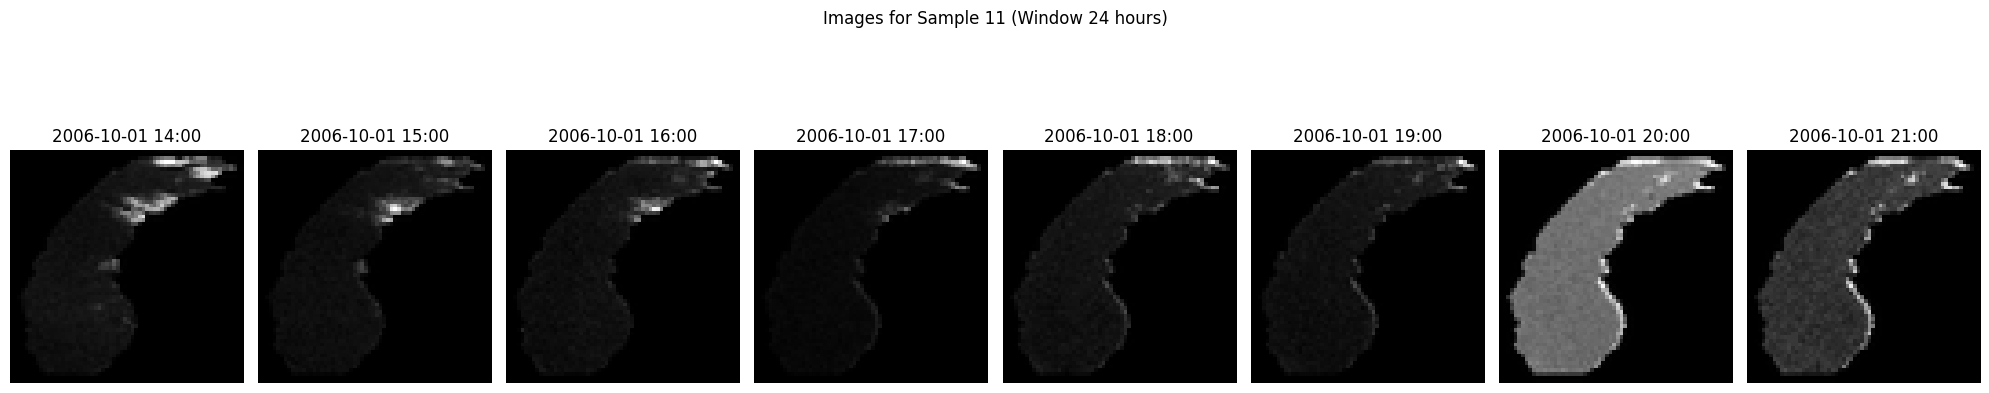

Sample 12 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,58.0,55.0,42.0,8.0,290.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.0,1017.9,0.00
1,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
2,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
3,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
4,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
5,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
6,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
7,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
8,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
9,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00


Target (y): 3


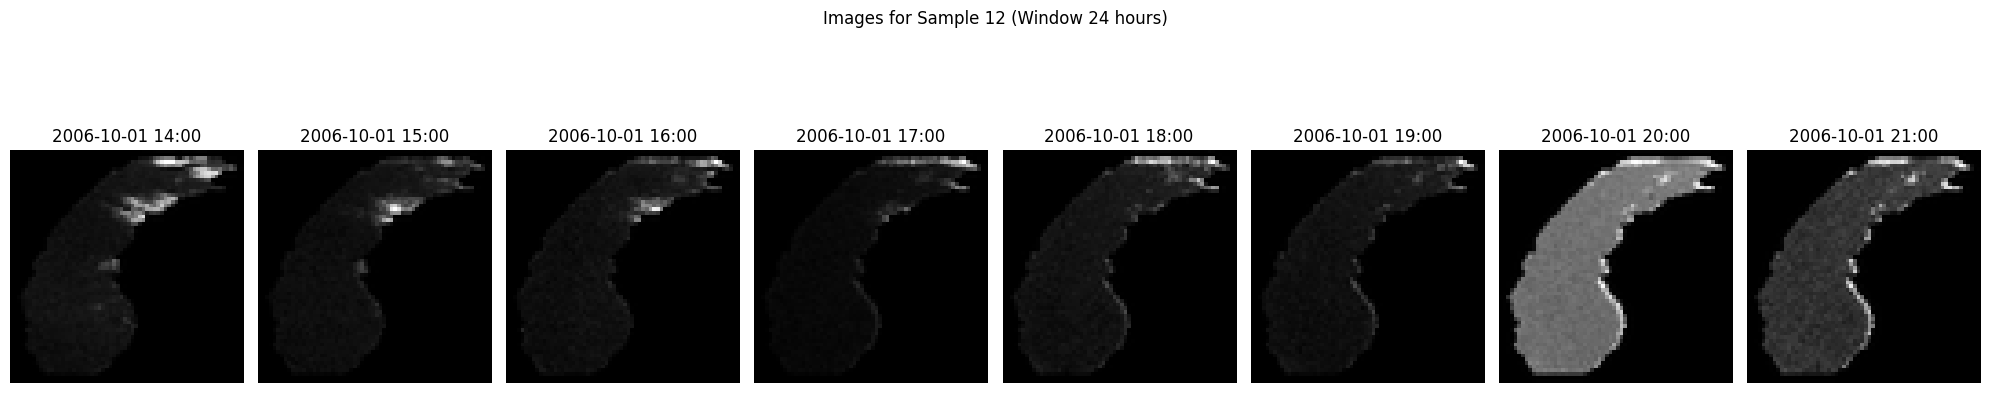

Sample 13 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,56.0,59.0,42.0,10.0,260.0,0.0,3600.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
1,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
2,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
3,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
4,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
5,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
6,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
7,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
8,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
9,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00


Target (y): 3


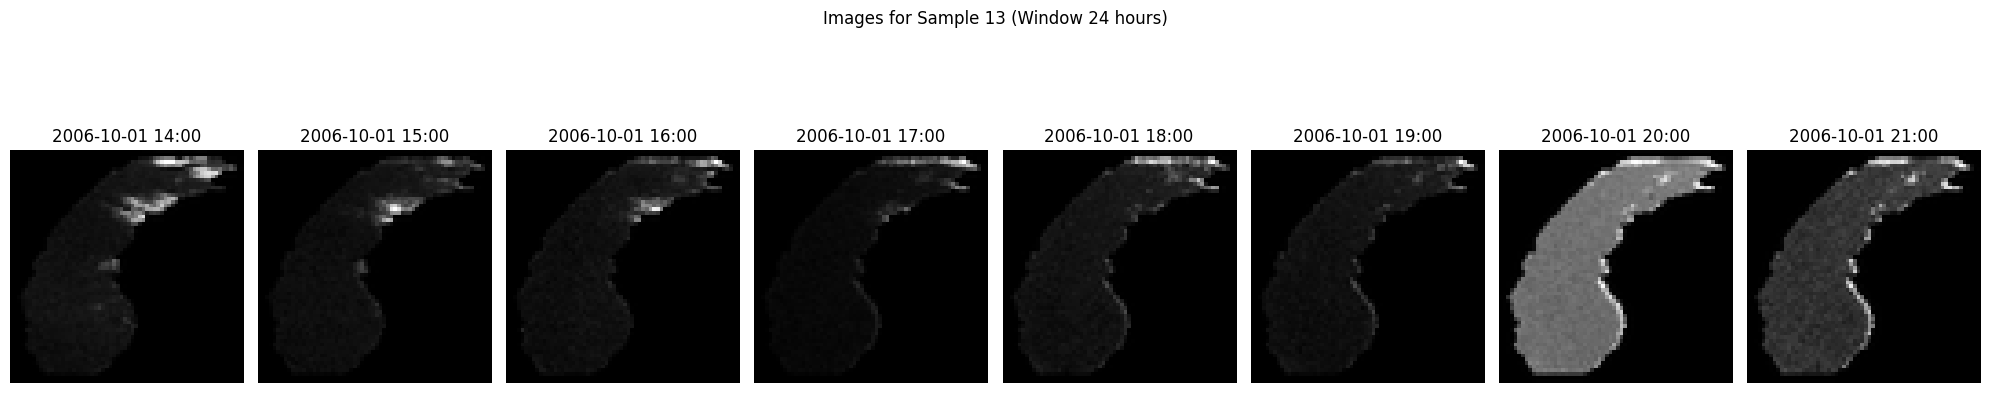

Sample 14 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,60.0,53.0,43.0,9.0,300.0,0.0,3800.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
1,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
2,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
3,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
4,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
5,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
6,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
7,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
8,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
9,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00


Target (y): 3


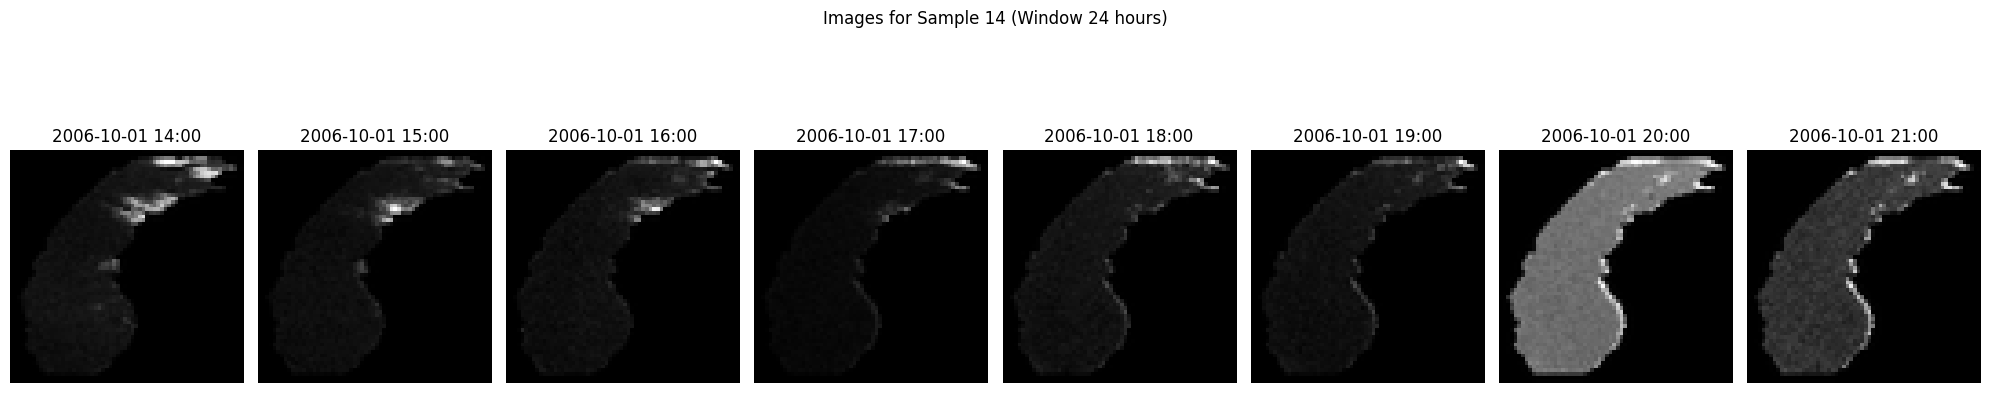

Sample 15 (Window Size: 24 hours)
Timeframe: 2006-10-01 14:00 to 2006-10-01 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,60.0,49.0,41.0,10.0,270.0,0.0,3600.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
1,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
2,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
3,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
4,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
5,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
6,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
7,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
8,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
9,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00


Target (y): 3


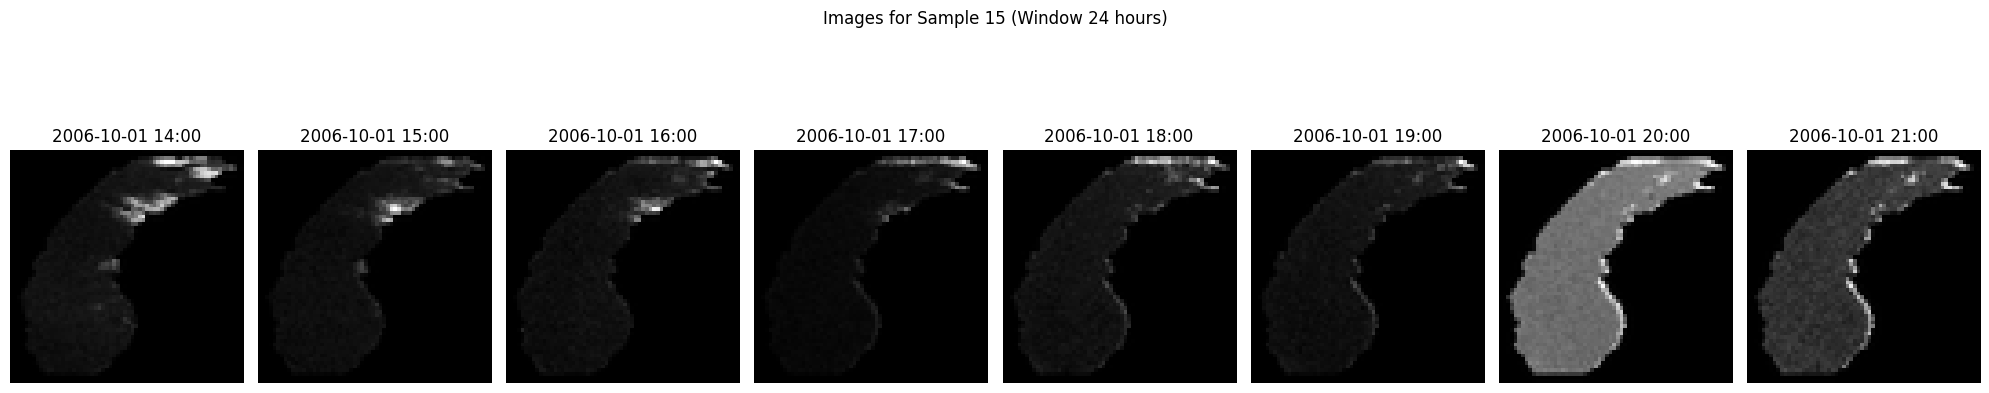

Sample 16 (Window Size: 24 hours)
Timeframe: 2006-10-01 15:00 to 2006-10-02 14:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,60.0,47.0,40.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.7,1017.6,0.00
1,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
2,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
3,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
4,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
5,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
6,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
7,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
8,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
9,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01


Target (y): 3


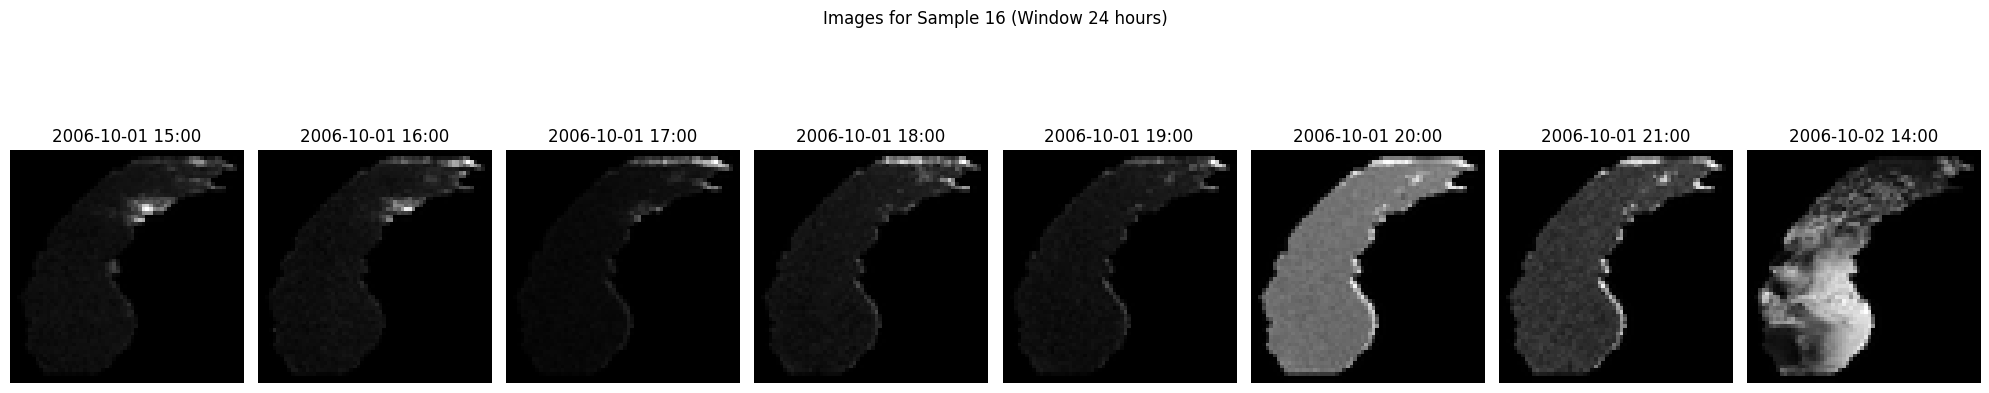

Sample 17 (Window Size: 24 hours)
Timeframe: 2006-10-01 16:00 to 2006-10-02 15:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,59.0,55.0,43.0,6.0,40.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
1,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
2,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
3,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
4,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
5,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
6,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
7,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
8,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
9,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00


Target (y): 3


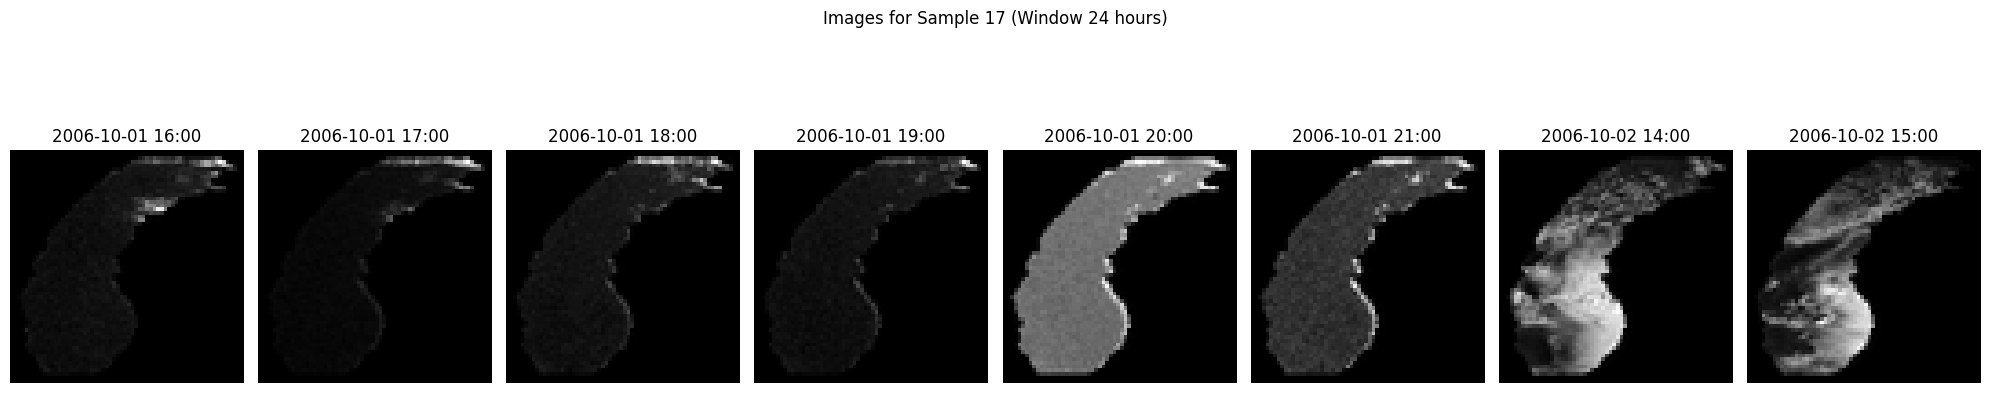

Sample 18 (Window Size: 24 hours)
Timeframe: 2006-10-01 17:00 to 2006-10-02 16:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,55.0,71.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,994.7,1017.8,1017.6,0.00
1,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
2,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
3,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
4,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
5,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
6,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
7,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
8,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
9,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00


Target (y): 3


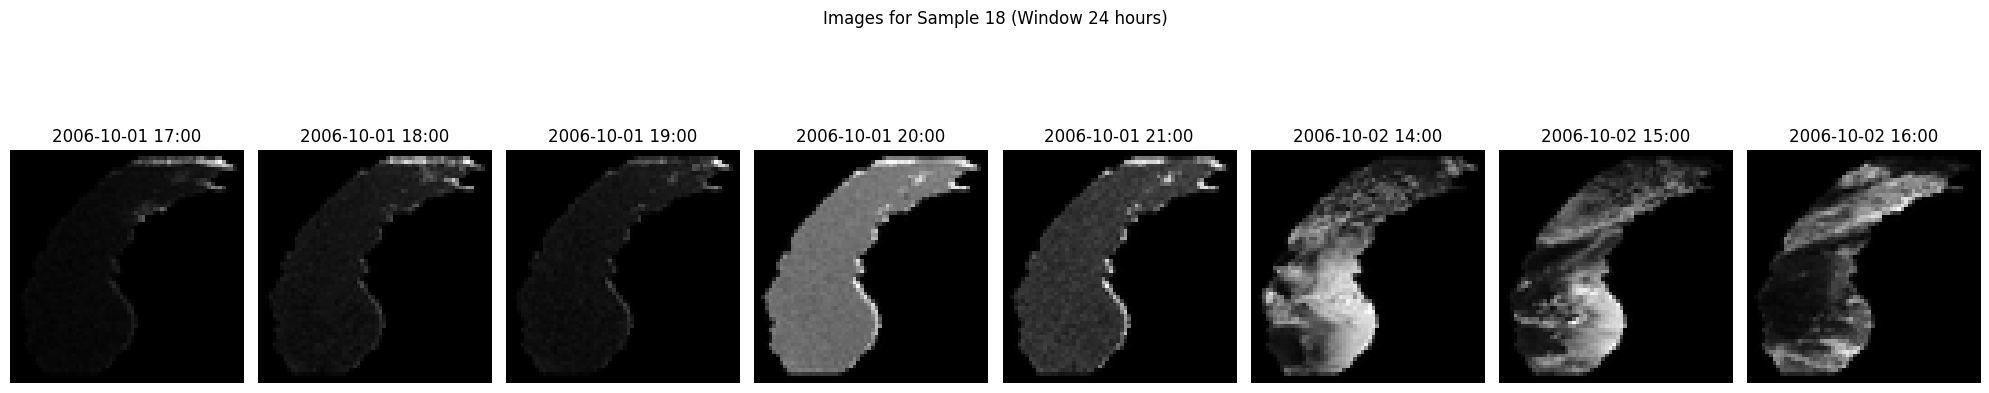

Sample 19 (Window Size: 24 hours)
Timeframe: 2006-10-01 18:00 to 2006-10-02 17:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,50.0,82.0,45.0,0.0,0.0,0.0,8000.0,0.0,0.0,10.0,994.7,1017.9,1017.6,0.00
1,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
2,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
3,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
4,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
5,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
6,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
7,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
8,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
9,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00


Target (y): 3


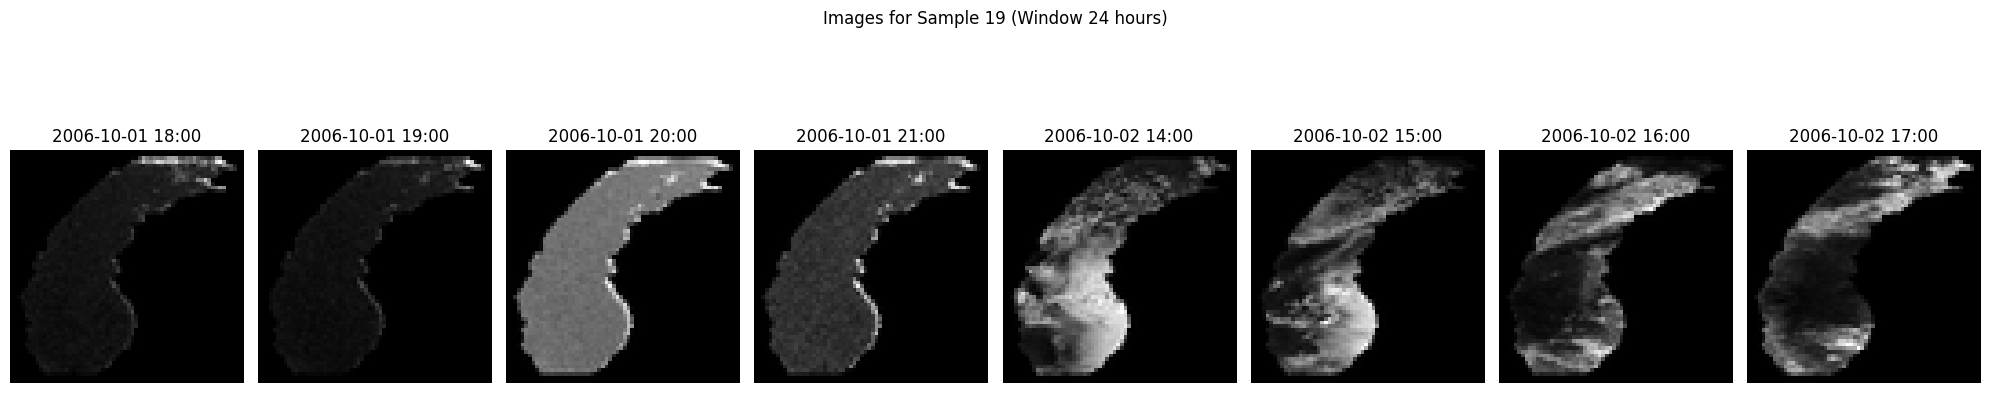

Sample 20 (Window Size: 24 hours)
Timeframe: 2006-10-01 19:00 to 2006-10-02 18:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,995.0,1018.1,1017.9,0.00
1,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
2,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
3,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
4,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
5,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
6,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
7,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
8,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
9,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00


Target (y): 3


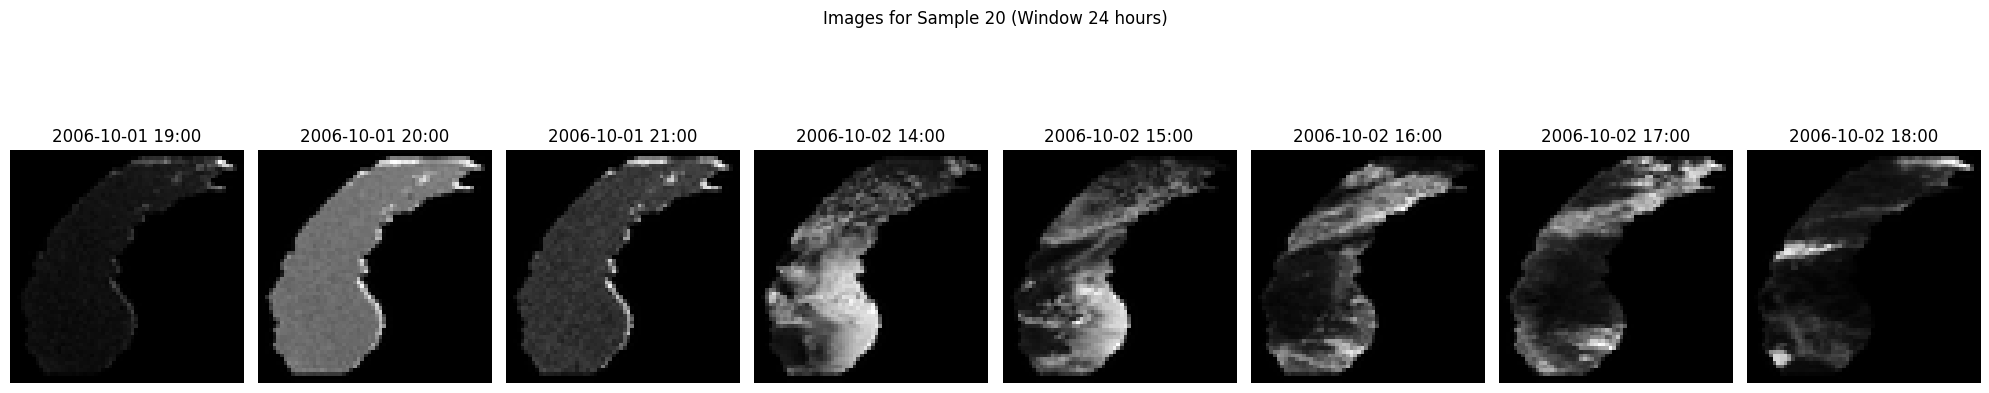

Sample 21 (Window Size: 24 hours)
Timeframe: 2006-10-01 20:00 to 2006-10-02 19:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,48.0,86.0,44.0,3.0,160.0,0.0,12000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
1,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
2,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
3,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
4,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
5,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
6,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
7,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
8,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00
9,41.0,95.0,40.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,990.7,1013.6,1013.5,0.00


Target (y): 3


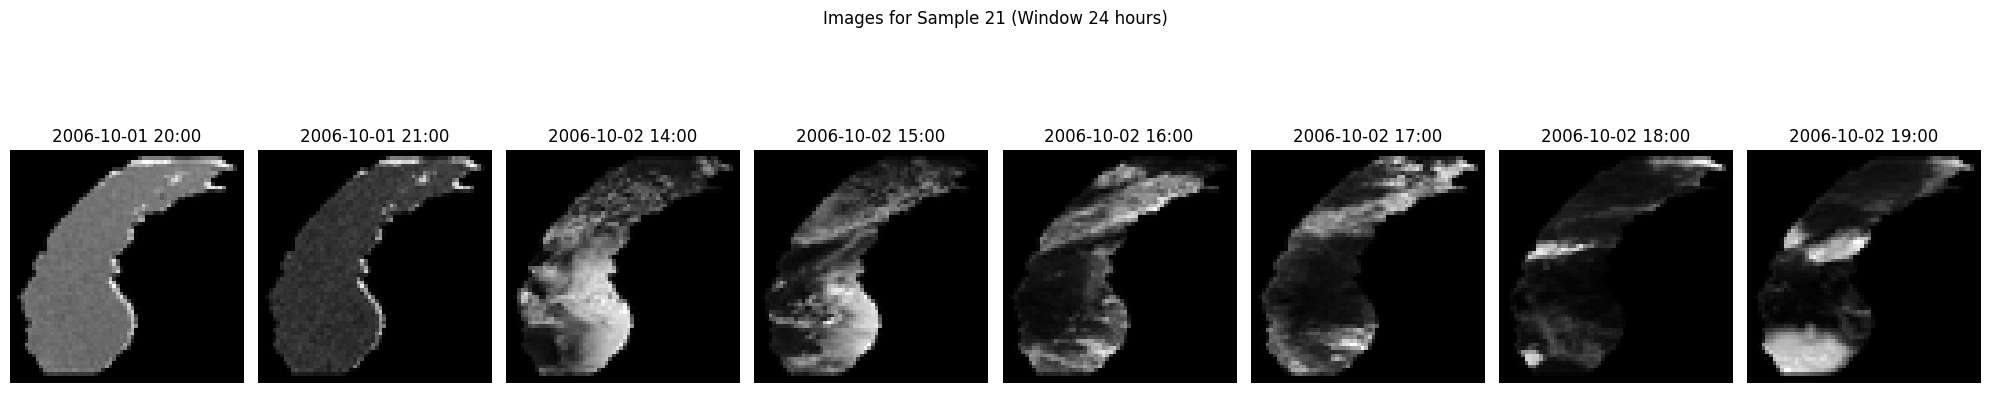

Sample 22 (Window Size: 24 hours)
Timeframe: 2006-10-01 21:00 to 2006-10-02 20:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,49.0,79.0,43.0,3.0,130.0,0.0,11000.0,0.0,0.0,10.0,994.3,1017.4,1017.3,0.00
1,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
2,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
3,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
4,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
5,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
6,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
7,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00
8,41.0,95.0,40.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,990.7,1013.6,1013.5,0.00
9,58.0,74.0,50.0,3.0,0.0,0.0,8500.0,0.0,0.0,10.0,990.7,1013.8,1013.5,0.00


Target (y): 3


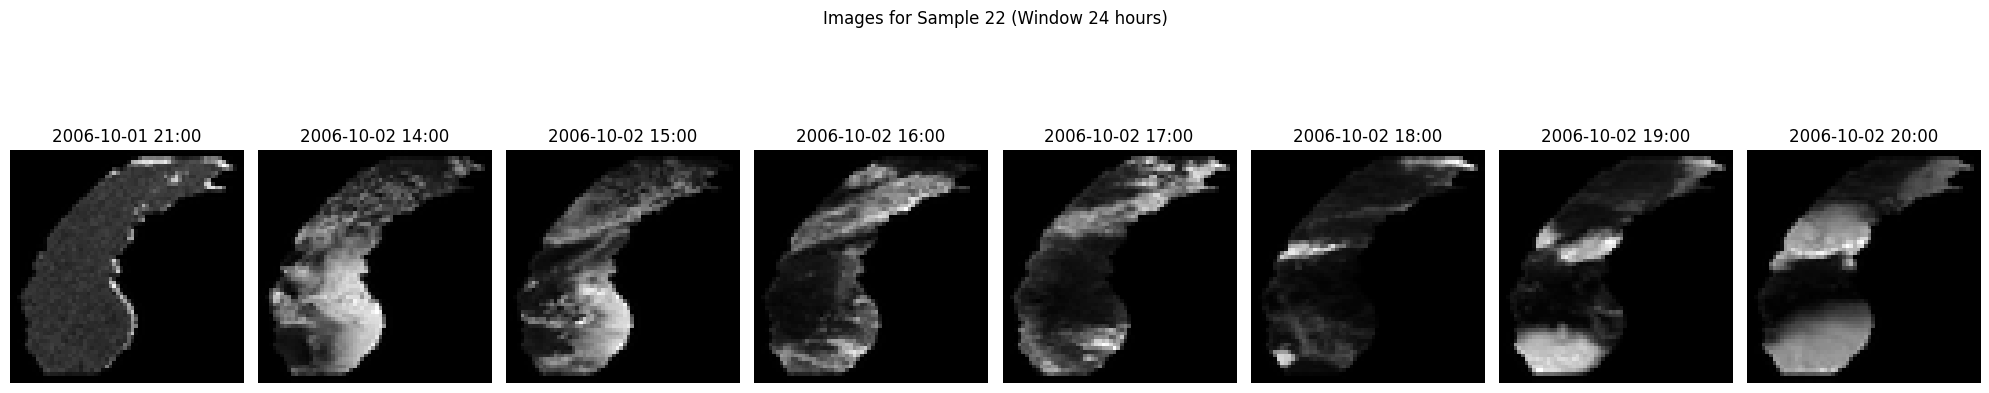

Sample 23 (Window Size: 24 hours)
Timeframe: 2006-10-02 14:00 to 2006-10-02 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,51.0,73.0,43.0,6.0,0.0,0.0,11000.0,0.0,0.0,10.0,993.7,1016.9,1016.6,0.00
1,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
2,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
3,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
4,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
5,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
6,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00
7,41.0,95.0,40.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,990.7,1013.6,1013.5,0.00
8,58.0,74.0,50.0,3.0,0.0,0.0,8500.0,0.0,0.0,10.0,990.7,1013.8,1013.5,0.00
9,64.0,67.0,53.0,7.0,0.0,0.0,7500.0,0.0,0.0,10.0,991.3,1014.3,1014.2,0.00


Target (y): 0


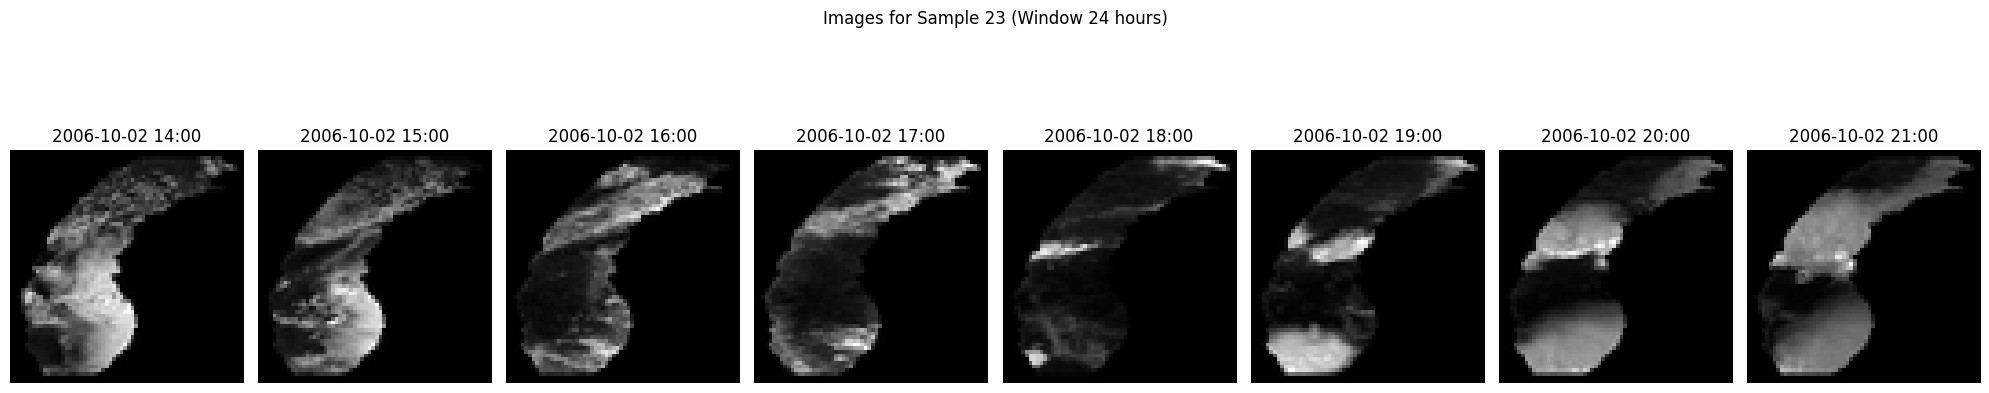

Sample 24 (Window Size: 24 hours)
Timeframe: 2006-10-02 14:00 to 2006-10-02 21:00
--------------------------------------------------
Meteorological Data:


,Temp_F,RH_pct,Dewpt_F,Wind_Spd_mph,Wind_Direction_deg,Peak_Wind_Gust_mph,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in
0,51.0,79.0,45.0,5.0,170.0,0.0,10000.0,0.0,0.0,10.0,994.0,1017.0,1016.9,0.00
1,50.0,92.0,48.0,0.0,0.0,0.0,6500.0,0.0,0.0,9.0,987.3,1010.2,1010.2,0.01
2,48.0,92.0,46.0,3.0,230.0,0.0,0.0,0.0,0.0,9.0,988.0,1010.8,1010.8,0.00
3,45.0,100.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,988.3,0.0,1011.2,0.00
4,43.0,100.0,43.0,0.0,0.0,0.0,4200.0,0.0,0.0,5.0,989.0,0.0,1011.9,0.00
5,42.0,95.0,41.0,0.0,0.0,0.0,5000.0,0.0,0.0,2.0,989.7,1012.8,1012.5,0.00
6,41.0,95.0,40.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,990.7,1013.6,1013.5,0.00
7,58.0,74.0,50.0,3.0,0.0,0.0,8500.0,0.0,0.0,10.0,990.7,1013.8,1013.5,0.00
8,64.0,67.0,53.0,7.0,0.0,0.0,7500.0,0.0,0.0,10.0,991.3,1014.3,1014.2,0.00
9,66.0,65.0,54.0,8.0,170.0,0.0,8000.0,0.0,0.0,10.0,991.0,1013.9,1013.9,0.00


Target (y): 0


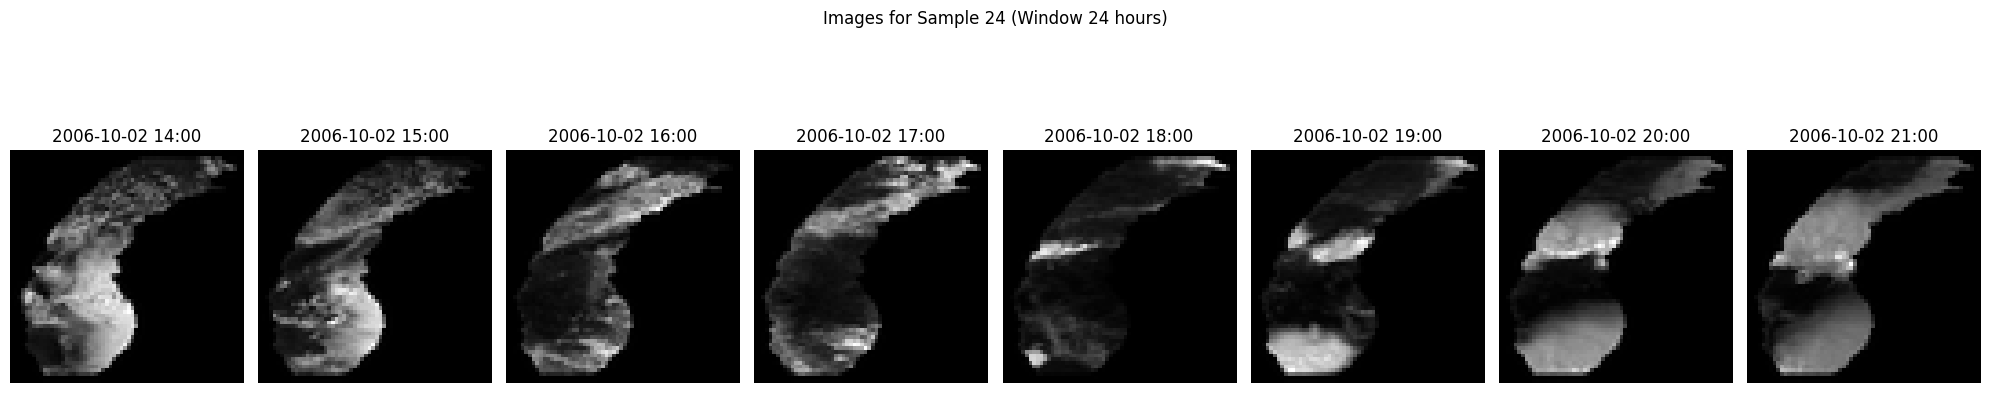

In [6]:
# Display the first 24 samples for a 24-hour window
display_sliding_window_samples(data_windows, window_size=24, num_samples=24)

## 3. Removing Corrupt Timestamps

Here’s how we will approach the task of filtering out corrupt time stamps:
- <b>Iterate Through Each Window Size:</b> For each window size, we will loop through the timestamps associated with the sliding windows. Our goal will be to identify valid windows where none of the timestamps are part of the corrupt_timestamps list.
- <b>Filter Valid Indices:</b> Using a list comprehension, we will check every sliding window's timestamps. If a window’s timestamps do not contain any corrupt entries, we will add that index to the list of valid indices for the respective window size.

In [7]:
# Load corrupt timestamps from the pickle file
with open('corrupt_timestamps.pkl', 'rb') as f:
    corrupt_timestamps = pickle.load(f)

print(f"Loaded {len(corrupt_timestamps)} corrupt timestamps")

Loaded 2920 corrupt timestamps


Once loaded, we'll calculate valid indices for each defined window size (24, 48, and 72 hours) by checking each window's timestamps and excluding those with any corrupt entries.

In [8]:
# Dictionary to store valid indices for each window size
valid_indices_all = {}

# Calculate valid indices for each window size
for window_size in [24, 48, 72]:
    print(f"\nCalculating valid indices for window size: {window_size} hours")
    
    # Get valid indices
    valid_indices_all[window_size] = [
        idx
        for idx, timestamps in enumerate(data_windows[window_size]['timestamps'])
        if not any(ts in corrupt_timestamps for ts in timestamps if ts != "No Image")
    ]
    
    print(f"Total valid windows ({window_size}): {len(valid_indices_all[window_size])} "
          f"out of {len(data_windows[window_size]['timestamps'])}")


Calculating valid indices for window size: 24 hours
Total valid windows (24): 39067 out of 47834

Calculating valid indices for window size: 48 hours
Total valid windows (48): 38995 out of 47786

Calculating valid indices for window size: 72 hours
Total valid windows (72): 38923 out of 47738


Now that we know which timestamps are corrputed, we are now going to filter them out:
- <b>Filter Data for Each Window Size:</b>
    For each window size, we will:
    - Retrieve the valid indices from valid_indices_all that we calculated earlier.
    - Use these indices to filter the corresponding data in data_windows. This step ensures that only valid sliding windows are included, based on the clean timestamps.
- <b>Store the Filtered Data:</b> For each window size, we will store the filtered meteorological data, image data, target labels, and timestamps in filtered_data_all. This allows us to keep the data organized and ready for further processing.

In [9]:
# Dictionary to store filtered data for each window size
filtered_data_all = {}

# Filter data for each window size
for window_size in [24, 48, 72]:
    print(f"\nFiltering data for window size: {window_size} hours")
    
    valid_indices = valid_indices_all[window_size]
    
    # Filter the data
    filtered_data_all[window_size] = {
        'X_meteo': np.array(data_windows[window_size]['X_meteo'])[valid_indices],
        'X_images': np.array(data_windows[window_size]['X_images'])[valid_indices],
        'y': np.array(data_windows[window_size]['y'])[valid_indices],
        'timestamps': np.array(data_windows[window_size]['timestamps'])[valid_indices],
    }
    
    # Print shapes
    print(f"Filtered X_meteo shape ({window_size}): {filtered_data_all[window_size]['X_meteo'].shape}")
    print(f"Filtered X_images shape ({window_size}): {filtered_data_all[window_size]['X_images'].shape}")
    print(f"Filtered y shape ({window_size}): {filtered_data_all[window_size]['y'].shape}")
    print(f"Filtered timestamps shape ({window_size}): {filtered_data_all[window_size]['timestamps'].shape}")


Filtering data for window size: 24 hours
Filtered X_meteo shape (24): (39067, 24, 14)
Filtered X_images shape (24): (39067, 32768)
Filtered y shape (24): (39067,)
Filtered timestamps shape (24): (39067, 8)

Filtering data for window size: 48 hours
Filtered X_meteo shape (48): (38995, 48, 14)
Filtered X_images shape (48): (38995, 65536)
Filtered y shape (48): (38995,)
Filtered timestamps shape (48): (38995, 16)

Filtering data for window size: 72 hours
Filtered X_meteo shape (72): (38923, 72, 14)
Filtered X_images shape (72): (38923, 98304)
Filtered y shape (72): (38923,)
Filtered timestamps shape (72): (38923, 24)


# 4. Stratified Train-Test Splitting

Now, let us perform a train, test and validation split on the data. But, we will not split the data randomly like we normally do.

- We are going to perfomr <b>Stratified Splitting</b>.
    - <b> What is Stratified Splitting of Data?</b>  
        A stratified split is a method of dividing data into training and testing (or validation) subsets while preserving the relative proportion of each class (or category) within the original dataset. This technique is commonly used in classification problems to ensure that all classes are fairly represented in both subsets.
- <b>Create a Balanced Validation Set:</b> Where we make sure that every class in the validation set has an equal number of samples, avoiding class imbalance during evaluation.
- <b>One Hot Encode Labels:</b> We convert both training and validation sets into one-hot encoded format.
    - <b>What is One Hot Encoding?</b>
         One-hot encoding is a technique used to represent categorical data as a binary matrix. Each category is converted into a unique vector with binary values (0 and 1), where only one element is set to 1 to indicate the presence of that category, and all other elements are set to 0.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical
import numpy as np

# Function to display class distributions
def print_class_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nClass distribution in {name}:")
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} ({count / len(y) * 100:.2f}%)")

# Function to split data and create balanced train/validation sets
def prepare_data_stratified(data, classes, test_size=0.2, samples_per_class=126):
    """
    Stratified split of data into train and validation sets with balanced validation classes.

    Args:
        data (dict): Filtered data for a specific window size.
        classes (array): Unique classes in the dataset.
        test_size (float): Proportion of data to use for validation.
        samples_per_class (int): Number of samples per class for the balanced validation set.

    Returns:
        dict: Train and validation datasets for the window size.
    """
    X_meteo = data['X_meteo']
    X_images = data['X_images'].reshape(-1, images_per_window_dict[len(X_meteo[0])], 64, 64, 1)
    y = data['y']
    timestamps = data['timestamps']

    # Stratified split into train and temp (temp will later be split into balanced validation)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, val_index in sss.split(X_meteo, y):
        X_train_meteo, X_temp_meteo = X_meteo[train_index], X_meteo[val_index]
        y_train, y_temp = y[train_index], y[val_index]
        X_train_images, X_temp_images = X_images[train_index], X_images[val_index]
        timestamps_train = timestamps[train_index]
        timestamps_temp = timestamps[val_index]

    # Create a balanced validation set with equal samples per class
    balanced_val_indices = []
    for c in classes:
        class_indices = np.where(y_temp == c)[0]
        if len(class_indices) < samples_per_class:
            balanced_val_indices.extend(np.random.choice(class_indices, samples_per_class, replace=True))
        else:
            balanced_val_indices.extend(np.random.choice(class_indices, samples_per_class, replace=False))

    # Prepare balanced validation data
    X_val_balanced_meteo = X_temp_meteo[balanced_val_indices]
    X_val_balanced_images = X_temp_images[balanced_val_indices]
    y_val_balanced = y_temp[balanced_val_indices]
    timestamps_val_balanced = timestamps_temp[balanced_val_indices]

    # One-hot encode the labels for train and validation
    y_train_onehot = to_categorical(y_train, num_classes=len(classes))
    y_val_balanced_onehot = to_categorical(y_val_balanced, num_classes=len(classes))

    # Print class distributions
    print_class_distribution(y_train, "Train Set")
    print_class_distribution(y_val_balanced, "Balanced Validation Set")

    return {
        'X_train_meteo': X_train_meteo,
        'X_train_images': X_train_images,
        'y_train': y_train_onehot,
        'timestamps_train': timestamps_train,
        'X_val_meteo': X_val_balanced_meteo,
        'X_val_images': X_val_balanced_images,
        'y_val': y_val_balanced_onehot,
        'timestamps_val': timestamps_val_balanced,
    }

# Prepare train and validation data for all window sizes
prepared_data_all = {}

for window_size in [24, 48, 72]:
    print(f"\nPreparing stratified data split for {window_size}-hour window.")
    classes = np.unique(filtered_data_all[window_size]['y'])
    prepared_data_all[window_size] = prepare_data_stratified(filtered_data_all[window_size], classes)

    # Print dataset shapes
    print(f"\nShapes for {window_size}-hour window size:")
    print(f"Train Meteo: {prepared_data_all[window_size]['X_train_meteo'].shape}, ")
    print(f"Train Images: {prepared_data_all[window_size]['X_train_images'].shape}, ")
    print(f"Train Labels: {prepared_data_all[window_size]['y_train'].shape}")
    print(f"Validation Meteo: {prepared_data_all[window_size]['X_val_meteo'].shape}, ")
    print(f"Validation Images: {prepared_data_all[window_size]['X_val_images'].shape}, ")
    print(f"Validation Labels: {prepared_data_all[window_size]['y_val'].shape}")



Preparing stratified data split for 24-hour window.

Class distribution in Train Set:
  Class 0: 422 (1.35%)
  Class 1: 1029 (3.29%)
  Class 2: 783 (2.51%)
  Class 3: 29019 (92.85%)

Class distribution in Balanced Validation Set:
  Class 0: 126 (25.00%)
  Class 1: 126 (25.00%)
  Class 2: 126 (25.00%)
  Class 3: 126 (25.00%)

Shapes for 24-hour window size:
Train Meteo: (31253, 24, 14), 
Train Images: (31253, 8, 64, 64, 1), 
Train Labels: (31253, 4)
Validation Meteo: (504, 24, 14), 
Validation Images: (504, 8, 64, 64, 1), 
Validation Labels: (504, 4)

Preparing stratified data split for 48-hour window.

Class distribution in Train Set:
  Class 0: 421 (1.35%)
  Class 1: 1027 (3.29%)
  Class 2: 783 (2.51%)
  Class 3: 28965 (92.85%)

Class distribution in Balanced Validation Set:
  Class 0: 126 (25.00%)
  Class 1: 126 (25.00%)
  Class 2: 126 (25.00%)
  Class 3: 126 (25.00%)

Shapes for 48-hour window size:
Train Meteo: (31196, 48, 14), 
Train Images: (31196, 16, 64, 64, 1), 
Train Labels:

## 5. Feature Importance

- In order for us to analyze the meterological data, to predict outcomes, we can make the process more efficient by choosing the most important featurfes to predict the outcomes.
- To do this, we’ll train a Random Forest model, which will help us evaluate how much each feature contributes to making accurate predictions.
- As soon as that is done, we'll calculate average importance scores for each feature, sort them by relevance, and pick the top ones. This process will allow us to focus on the key factors driving predictions, making our analysis more streamlined and efficient.

<b>Helper Function: Compute Top Features</b>

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Compute top features (meteorological data only) after filtering
def compute_top_features_filtered(X_train_meteo, y_train, top_n=10):
    # Flatten the meteorological data
    X_flat = X_train_meteo.reshape(X_train_meteo.shape[0], -1)
    
    # Initialize and train the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_flat, y_train.argmax(axis=1))  # Convert one-hot to class indices
    
    # Get feature importances
    feature_importance = rf.feature_importances_
    
    # Reshape importance to match original feature structure
    reshaped_importance = feature_importance.reshape(X_train_meteo.shape[1], -1)
    
    # Aggregate importance across features
    aggregated_importance = reshaped_importance.mean(axis=0)
    
    # Create a DataFrame for easier handling
    importance_df = pd.DataFrame({
        'Feature': [f"Feature {i}" for i in range(X_train_meteo.shape[2])],
        'Importance': aggregated_importance
    })
    
    # Sort features by importance
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    
    # Select top_n features
    top_features = importance_df.head(top_n).index.tolist()
    
    return top_features

Now, we'll use the helper function we defined above, to do the following:
- <b>Iterate over Window Sizes</b> (24, 48, and 72 hours)
- <b>Identify Top Features:</b> Using the helper function to compute the top features, we compute the average feature importance, and select a number of top contenders to be the most important features.
- <b>Reduce Meteorological Data: </b>We’ll filter the training and validation meteorological data, keeping only the identified top features. This reduction helps streamline the dataset without losing critical information.

In [12]:
# Dictionary to store reduced data for all window sizes
reduced_data_filtered_all = {}

# Function to compute top features for all window sizes
for window_size in tqdm([24, 48, 72]):
    print(f"\nComputing top features for window size: {window_size} hours")

    # Extract train data for the current window size
    X_train_meteo = prepared_data_all[window_size]['X_train_meteo']
    y_train = prepared_data_all[window_size]['y_train']
    
    # Compute top features
    top_features_filtered = compute_top_features_filtered(
        X_train_meteo,
        y_train,
        top_n=10
    )
    print(f"Top 10 Features for {window_size}-hour Window (Filtered): {top_features_filtered}")

    # Reduce meteorological data to the top features
    X_train_meteo_reduced = X_train_meteo[:, :, top_features_filtered]
    X_val_meteo_reduced = prepared_data_all[window_size]['X_val_meteo'][:, :, top_features_filtered]

    # Store reduced data for the current window size
    reduced_data_filtered_all[window_size] = {
        'X_train_meteo': X_train_meteo_reduced,
        'X_train_images': prepared_data_all[window_size]['X_train_images'],
        'y_train': prepared_data_all[window_size]['y_train'],
        'timestamps_train': prepared_data_all[window_size]['timestamps_train'],
        'X_val_meteo': X_val_meteo_reduced,
        'X_val_images': prepared_data_all[window_size]['X_val_images'],
        'y_val': prepared_data_all[window_size]['y_val'],
        'timestamps_val': prepared_data_all[window_size]['timestamps_val'],
    }

    # Print reduced shapes
    print(f"Reduced Train Meteo Shape ({window_size}): {X_train_meteo_reduced.shape}")
    print(f"Reduced Validation Meteo Shape ({window_size}): {X_val_meteo_reduced.shape}")

  0%|          | 0/3 [00:00<?, ?it/s]


Computing top features for window size: 24 hours


 33%|███▎      | 1/3 [00:19<00:39, 19.85s/it]

Top 10 Features for 24-hour Window (Filtered): [1, 11, 0, 2, 12, 10, 6, 4, 3, 7]
Reduced Train Meteo Shape (24): (31253, 24, 10)
Reduced Validation Meteo Shape (24): (504, 24, 10)

Computing top features for window size: 48 hours


 67%|██████▋   | 2/3 [00:52<00:27, 27.62s/it]

Top 10 Features for 48-hour Window (Filtered): [1, 0, 12, 11, 2, 6, 10, 3, 4, 7]
Reduced Train Meteo Shape (48): (31196, 48, 10)
Reduced Validation Meteo Shape (48): (504, 48, 10)

Computing top features for window size: 72 hours


100%|██████████| 3/3 [01:41<00:00, 33.99s/it]

Top 10 Features for 72-hour Window (Filtered): [1, 0, 12, 2, 11, 10, 6, 3, 4, 7]
Reduced Train Meteo Shape (72): (31138, 72, 10)
Reduced Validation Meteo Shape (72): (504, 72, 10)


**Visualizing the Most Important Features**

We'll now visualize the first few samples of the filtered and reduced data for the selected window size (e.g., 72 hours). So that we get a chance to examine the structure and content of the meteorological data, associated satellite images, and target labels to ensure everything is properly aligned and formatted for training.



In [13]:
def display_first_n_samples(reduced_data, window_size=24, num_samples=20):
    """
    Display the first n samples of the filtered and reduced data, 
    showing meteorological data, associated images with timestamps, and target labels.
    
    Args:
        reduced_data (dict): Contains 'X_train_meteo', 'X_train_images', 'y_train', 'timestamps_train', 
                             'X_val_meteo', 'X_val_images', 'y_val', 'timestamps_val' for each window size.
        window_size (int): Size of the window (24, 48, 72 hours).
        num_samples (int): Number of samples to display.
    """
    # Extract training data
    X_meteo = reduced_data[window_size]['X_train_meteo']
    X_images = reduced_data[window_size]['X_train_images']
    y = reduced_data[window_size]['y_train']
    timestamps = reduced_data[window_size]['timestamps_train']
    
    # Convert one-hot labels to class indices
    y_labels = np.argmax(y, axis=1)
    
    # Define feature column names for meteorological data
    top_features = [
        f"Feature {i}" for i in range(X_meteo.shape[2])
    ]  # Adjusted to match the reduced features
    
    # Define class names based on unique classes
    num_classes = y.shape[1]
    class_names = [f"Class {i}" for i in range(num_classes)]
    
    for i in range(min(num_samples, len(X_meteo))):
        print(f"\n=== Sample {i+1} ===")
        print(f"Target (y): {class_names[y_labels[i]]}")
        print("Meteorological Data:")
        
        # Create a DataFrame for meteorological data
        meteo_df = pd.DataFrame(X_meteo[i], columns=top_features)
        display(meteo_df)
        
        # Plot images with timestamps
        images = X_images[i]  # Shape: (num_images, 64, 64, 1)
        num_images = images.shape[0]
        
        # Create a figure with subplots
        fig, axes = plt.subplots(1, num_images, figsize=(20, 3))
        fig.suptitle(f"Sample {i+1} Images ({window_size}-hour Window)", fontsize=16)
        
        for j in range(num_images):
            img = images[j].reshape(64, 64)  # Reshape image
            ax = axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            # Get corresponding timestamp
            ts = timestamps[i][j] if j < len(timestamps[i]) else "No Image"
            ax.set_title(ts if ts != "No Image" else "Placeholder")
        
        plt.tight_layout()
        plt.show()


=== Sample 1 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,88.0,1024.6,42.0,39.0,1024.0,1001.0,1100.0,80.0,5.0,0.0
1,88.0,1024.7,42.0,39.0,1024.4,1001.3,1100.0,70.0,3.0,0.0
2,88.0,1024.6,43.0,40.0,1024.0,1001.0,1100.0,80.0,6.0,0.0
3,85.0,1024.4,44.0,40.0,1024.0,1001.0,1100.0,90.0,7.0,0.0
4,82.0,1023.6,45.0,40.0,1023.0,1000.0,1100.0,120.0,8.0,0.0
5,79.0,1022.9,46.0,40.0,1022.4,999.3,1300.0,130.0,8.0,0.0
6,73.0,1021.7,48.0,40.0,1021.3,998.3,1600.0,100.0,11.0,0.0
7,68.0,1021.5,49.0,39.0,1021.0,998.0,2200.0,0.0,7.0,0.0
8,70.0,0.0,48.0,39.0,1021.3,998.3,2200.0,110.0,8.0,6000.0
9,73.0,1022.2,46.0,38.0,1021.7,998.7,2000.0,140.0,6.0,0.0


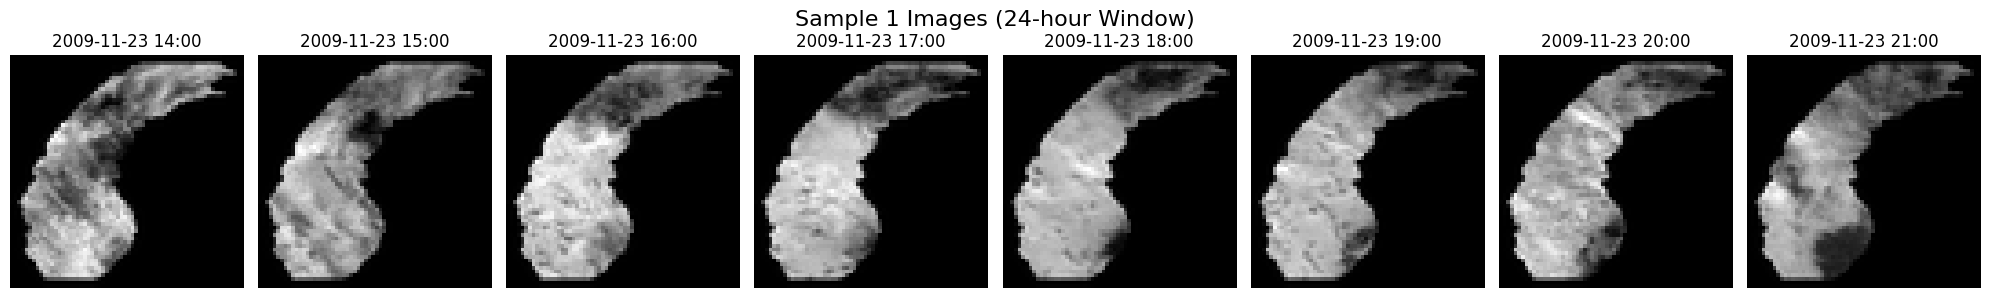


=== Sample 2 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,79.0,1003.7,48.0,42.0,1003.4,980.7,1800.0,240.0,8.0,2500.0
1,73.0,1003.1,48.0,40.0,1002.7,980.0,1800.0,240.0,10.0,2700.0
2,70.0,1002.6,48.0,39.0,1002.4,979.7,2500.0,250.0,11.0,0.0
3,70.0,1003.1,47.0,38.0,1002.7,980.0,2300.0,250.0,11.0,0.0
4,73.0,1003.9,46.0,38.0,1003.7,981.0,2300.0,270.0,9.0,0.0
5,73.0,1004.2,46.0,38.0,1004.1,981.4,2300.0,270.0,6.0,0.0
6,76.0,1004.7,44.0,37.0,1004.4,981.7,2300.0,290.0,7.0,0.0
7,76.0,1004.6,43.0,36.0,1004.4,981.7,2300.0,290.0,6.0,0.0
8,76.0,1005.0,43.0,36.0,1004.7,982.0,2000.0,0.0,0.0,0.0
9,85.0,1005.0,41.0,37.0,1004.7,982.0,2000.0,0.0,0.0,0.0


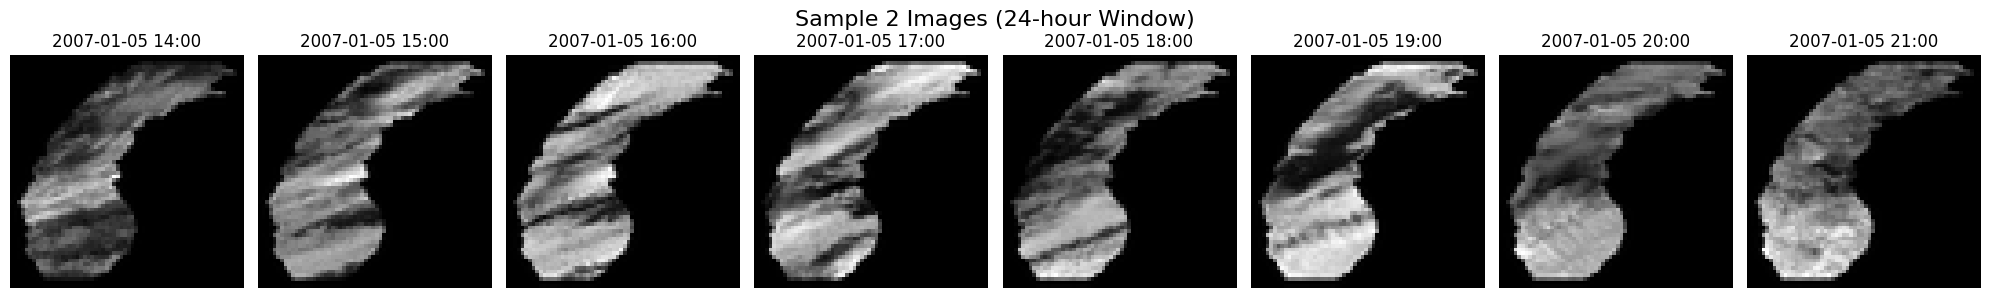


=== Sample 3 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,93.0,0.0,45.0,43.0,1010.5,987.7,700.0,0.0,0.0,1300.0
1,96.0,1011.0,43.0,42.0,1010.5,987.7,700.0,0.0,0.0,0.0
2,96.0,1010.8,43.0,42.0,1010.5,987.7,600.0,0.0,0.0,1100.0
3,96.0,1010.4,43.0,42.0,1010.2,987.3,500.0,0.0,0.0,0.0
4,100.0,0.0,43.0,43.0,1009.8,987.0,500.0,0.0,0.0,0.0
5,88.0,1020.1,37.0,34.0,1019.6,996.7,1200.0,100.0,8.0,0.0
6,85.0,1018.9,38.0,34.0,1018.3,995.3,1200.0,110.0,8.0,0.0
7,85.0,1018.3,38.0,34.0,1017.6,994.7,1200.0,120.0,7.0,0.0
8,89.0,1017.6,38.0,35.0,1016.9,994.0,1100.0,0.0,5.0,0.0
9,89.0,1017.0,38.0,35.0,1016.6,993.7,1100.0,110.0,3.0,0.0


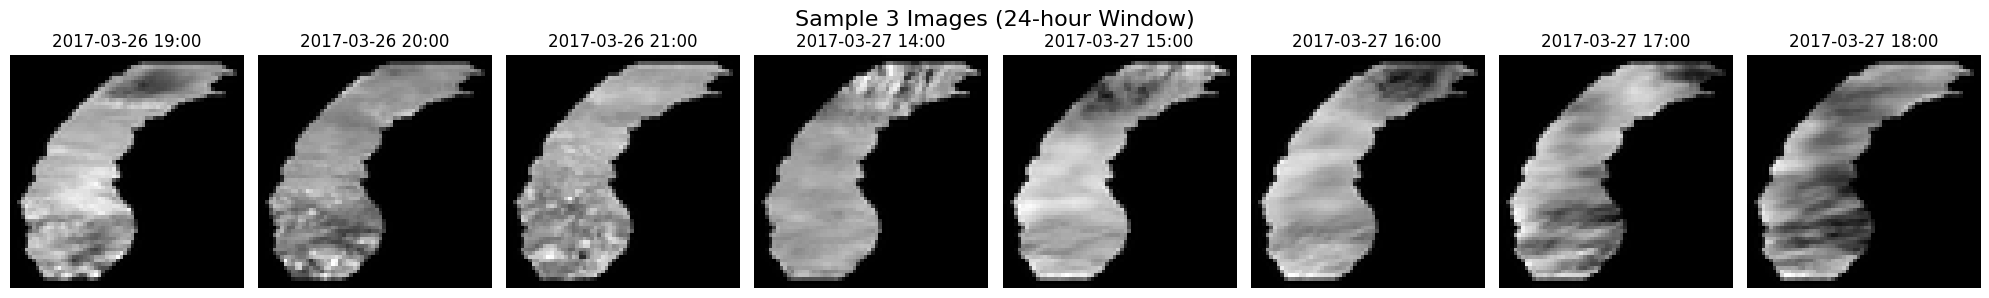


=== Sample 4 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,77.0,1025.8,24.0,18.0,1024.7,1001.6,1300.0,340.0,10.0,20000.0
1,74.0,1026.4,24.0,17.0,1025.4,1002.3,1500.0,360.0,8.0,0.0
2,70.0,1026.7,24.0,16.0,1025.7,1002.6,1700.0,360.0,8.0,0.0
3,68.0,1027.3,24.0,15.0,1026.4,1003.3,1900.0,360.0,6.0,0.0
4,71.0,1027.7,23.0,15.0,1026.8,1003.6,2100.0,360.0,5.0,0.0
5,73.0,1027.9,19.0,12.0,1026.8,1003.6,2100.0,90.0,7.0,0.0
6,76.0,1028.6,17.0,11.0,1027.4,1004.3,2100.0,0.0,0.0,0.0
7,88.0,1029.0,13.0,10.0,1027.8,1004.6,0.0,0.0,0.0,0.0
8,79.0,1029.6,9.0,4.0,1028.4,1005.3,2200.0,0.0,0.0,0.0
9,91.0,1029.2,5.0,3.0,1027.8,1004.6,0.0,0.0,0.0,0.0


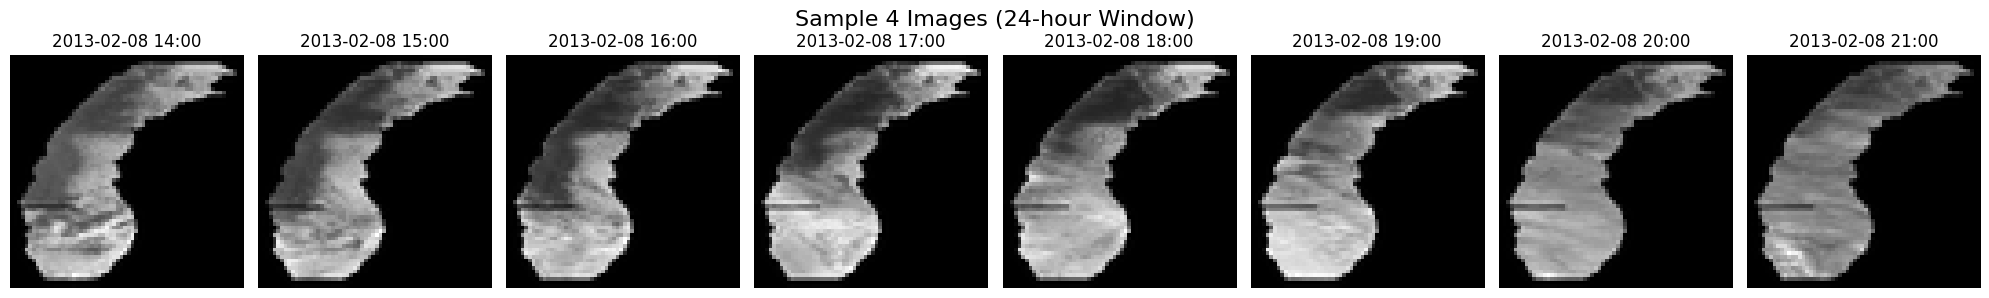


=== Sample 5 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,75.0,1025.6,10.0,4.0,1024.4,1001.3,5000.0,210.0,8.0,0.0
1,75.0,1025.7,10.0,4.0,1024.4,1001.3,4900.0,220.0,8.0,0.0
2,72.0,1026.5,10.0,3.0,1025.1,1002.0,2800.0,0.0,7.0,4700.0
3,72.0,1027.0,10.0,3.0,1025.7,1002.6,2500.0,210.0,6.0,4500.0
4,72.0,1027.1,10.0,3.0,1025.7,1002.6,4900.0,200.0,6.0,0.0
5,76.0,1026.8,9.0,3.0,1025.4,1002.3,4400.0,210.0,6.0,0.0
6,61.0,1033.8,14.0,3.0,1032.5,1009.3,3800.0,310.0,10.0,0.0
7,63.0,1034.7,14.0,4.0,1033.2,1010.0,3600.0,310.0,11.0,0.0
8,66.0,1035.0,15.0,6.0,1033.9,1010.6,3600.0,290.0,10.0,0.0
9,64.0,1035.4,16.0,6.0,1034.2,1011.0,3600.0,250.0,7.0,0.0


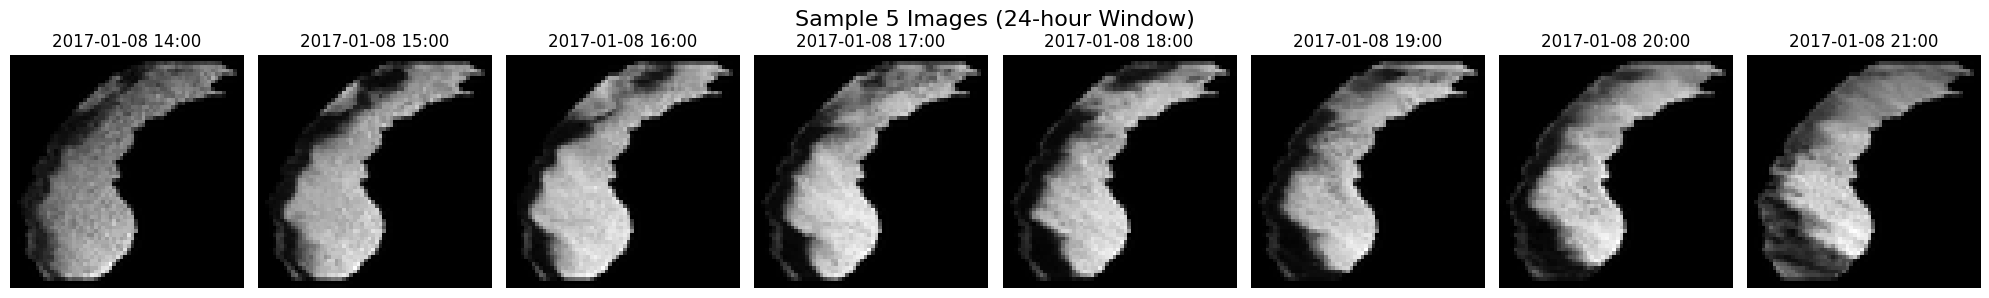


=== Sample 6 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,77.0,1020.1,20.0,14.0,1019.3,996.3,11000.0,160.0,5.0,0.0
1,77.0,1020.0,21.0,15.0,1019.0,996.0,11000.0,140.0,7.0,12000.0
2,77.0,1019.1,22.0,16.0,1017.9,995.0,11000.0,160.0,7.0,20000.0
3,68.0,1017.5,26.0,17.0,1016.6,993.7,15000.0,150.0,6.0,25000.0
4,63.0,1015.8,30.0,19.0,1014.9,992.0,15000.0,140.0,7.0,25000.0
5,58.0,1015.3,33.0,20.0,1014.6,991.7,6500.0,130.0,6.0,9000.0
6,56.0,1014.0,36.0,22.0,1013.2,990.3,4200.0,0.0,5.0,9000.0
7,59.0,0.0,36.0,23.0,1011.9,989.0,2000.0,150.0,8.0,5000.0
8,66.0,1010.3,36.0,26.0,1009.5,986.7,2900.0,140.0,7.0,3800.0
9,64.0,1008.9,36.0,25.0,1008.1,985.4,3600.0,130.0,7.0,4300.0


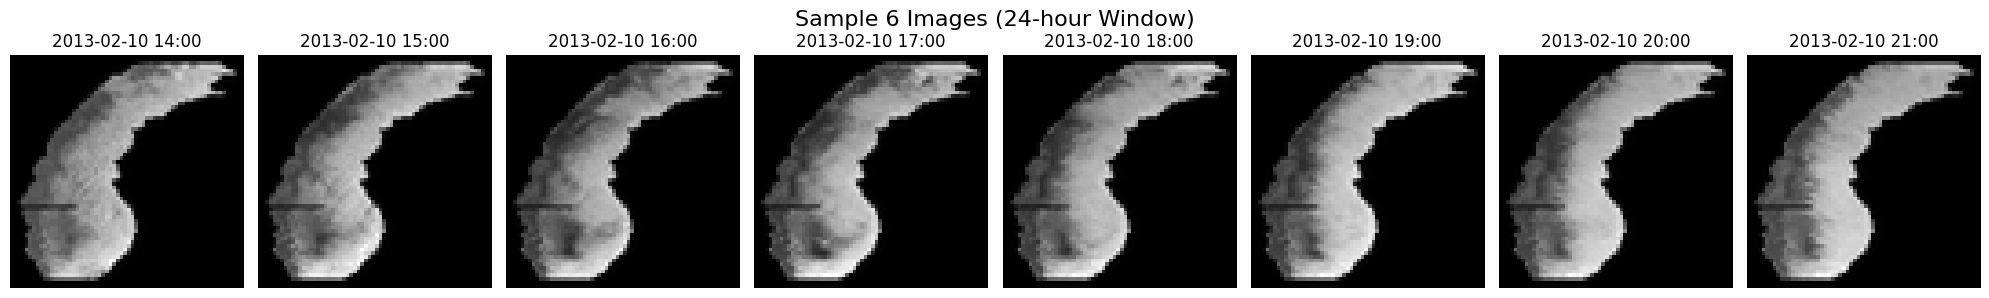


=== Sample 7 ===
Target (y): Class 2
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,73.0,0.0,27.0,19.0,1015.2,992.3,2400.0,240.0,10.0,4000.0
1,71.0,1016.1,25.0,17.0,1015.2,992.3,2600.0,240.0,8.0,3600.0
2,74.0,1015.8,25.0,18.0,1014.9,992.0,2300.0,240.0,6.0,3600.0
3,77.0,1015.7,25.0,19.0,1014.9,992.0,3000.0,0.0,7.0,0.0
4,85.0,0.0,25.0,21.0,1014.9,992.0,2000.0,190.0,5.0,0.0
5,87.0,1016.1,25.0,22.0,1015.2,992.3,1800.0,180.0,3.0,2700.0
6,87.0,1016.6,25.0,22.0,1015.6,992.7,1800.0,210.0,6.0,3200.0
7,85.0,0.0,25.0,21.0,1015.9,993.0,2600.0,220.0,5.0,3300.0
8,85.0,0.0,25.0,21.0,1015.9,993.0,800.0,200.0,5.0,1600.0
9,77.0,1017.4,25.0,19.0,1016.6,993.7,1800.0,230.0,9.0,3800.0


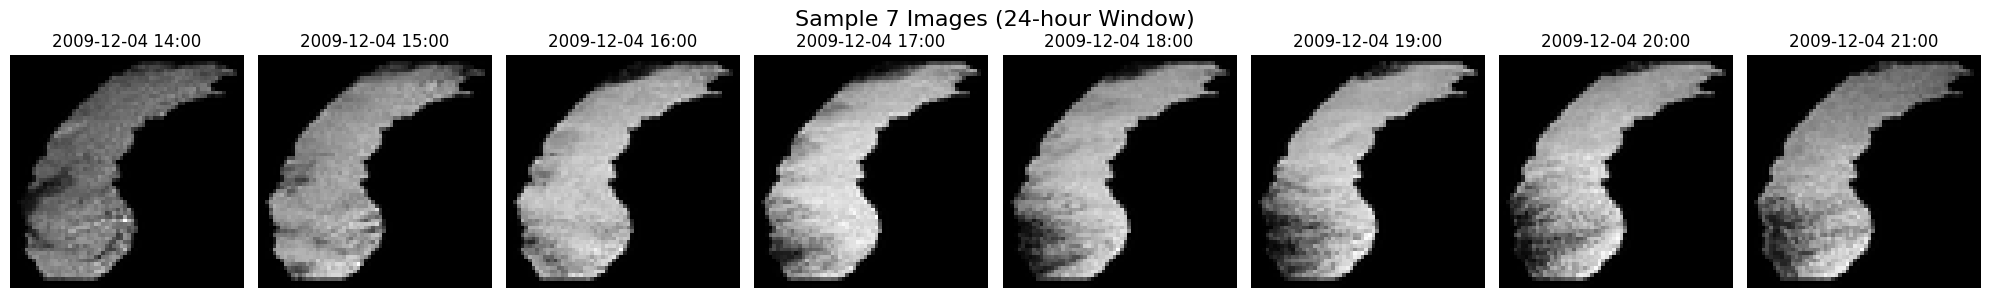


=== Sample 8 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,92.0,1013.9,40.0,38.0,1013.5,990.7,25000.0,0.0,0.0,0.0
1,79.0,1013.8,50.0,44.0,1013.5,990.7,25000.0,0.0,0.0,0.0
2,63.0,1013.9,57.0,45.0,1013.5,990.7,25000.0,0.0,5.0,0.0
3,59.0,1013.6,61.0,47.0,1013.2,990.3,3500.0,0.0,6.0,25000.0
4,55.0,1013.4,61.0,45.0,1013.2,990.3,3000.0,240.0,5.0,25000.0
5,44.0,1012.5,63.0,41.0,1012.5,989.7,4000.0,260.0,6.0,25000.0
6,44.0,1011.7,65.0,43.0,1011.5,988.7,4000.0,0.0,7.0,25000.0
7,43.0,1011.3,65.0,42.0,1011.2,988.3,3000.0,250.0,6.0,15000.0
8,48.0,1011.0,64.0,44.0,1010.8,988.0,3000.0,0.0,0.0,15000.0
9,64.0,1010.7,61.0,49.0,1010.5,987.7,15000.0,0.0,0.0,25000.0


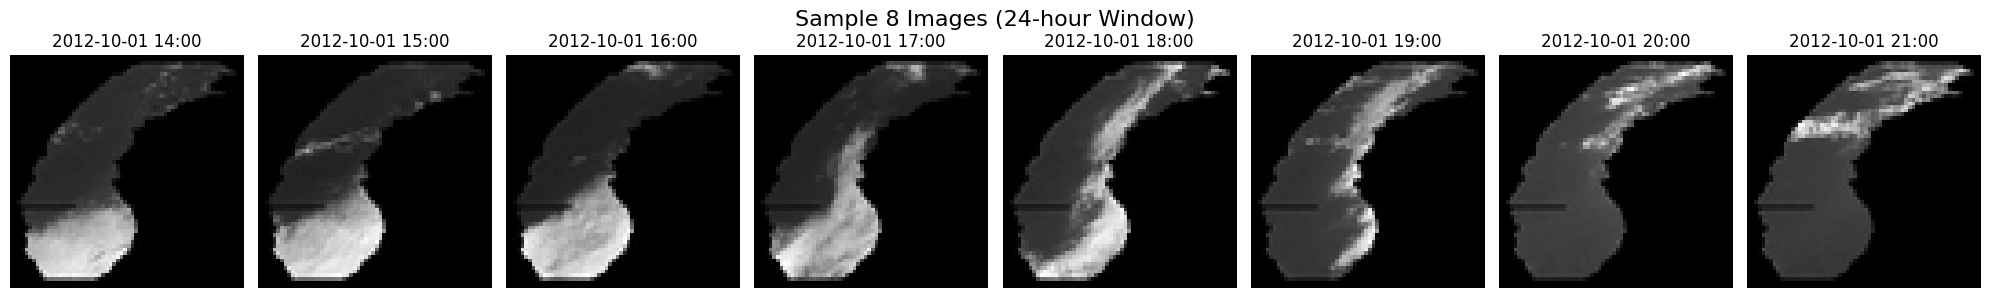


=== Sample 9 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,67.0,1021.2,21.0,12.0,1020.3,997.3,2000.0,110.0,6.0,20000.0
1,64.0,1021.4,23.0,13.0,1020.3,997.3,2000.0,0.0,0.0,20000.0
2,59.0,1020.4,25.0,13.0,1019.6,996.7,20000.0,0.0,0.0,0.0
3,60.0,1019.4,27.0,15.0,1018.3,995.3,20000.0,50.0,13.0,0.0
4,57.0,1018.7,28.0,15.0,1017.6,994.7,20000.0,50.0,9.0,0.0
5,53.0,1018.7,30.0,15.0,1017.6,994.7,20000.0,40.0,7.0,0.0
6,55.0,1019.4,29.0,15.0,1018.6,995.7,20000.0,0.0,0.0,0.0
7,57.0,1020.0,27.0,14.0,1019.0,996.0,20000.0,0.0,0.0,0.0
8,64.0,1020.2,24.0,14.0,1019.3,996.3,20000.0,0.0,0.0,0.0
9,76.0,1020.7,19.0,13.0,1019.6,996.7,0.0,0.0,0.0,0.0


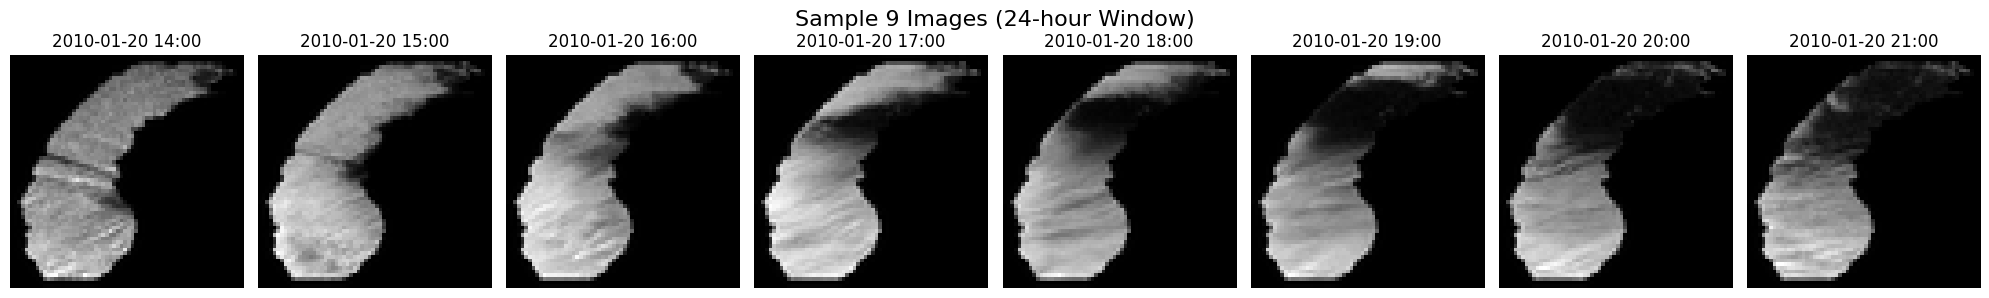


=== Sample 10 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,72.0,1014.0,34.0,26.0,1013.5,990.7,2200.0,240.0,9.0,2900.0
1,75.0,1013.8,34.0,27.0,1013.2,990.3,2000.0,240.0,11.0,0.0
2,84.0,1013.0,33.0,29.0,1012.2,989.3,2100.0,240.0,7.0,0.0
3,80.0,0.0,34.0,28.0,1011.5,988.7,2300.0,240.0,8.0,3000.0
4,81.0,1011.5,34.0,29.0,1010.8,988.0,2900.0,250.0,9.0,0.0
5,81.0,1011.6,34.0,29.0,1010.8,988.0,2700.0,260.0,8.0,0.0
6,84.0,1013.0,20.0,16.0,1012.2,989.3,1200.0,60.0,6.0,2000.0
7,80.0,1013.6,21.0,16.0,1012.5,989.7,3200.0,40.0,7.0,0.0
8,77.0,1014.0,21.0,15.0,1013.2,990.3,1800.0,40.0,7.0,4200.0
9,74.0,1014.5,22.0,15.0,1013.5,990.7,2000.0,30.0,8.0,6500.0


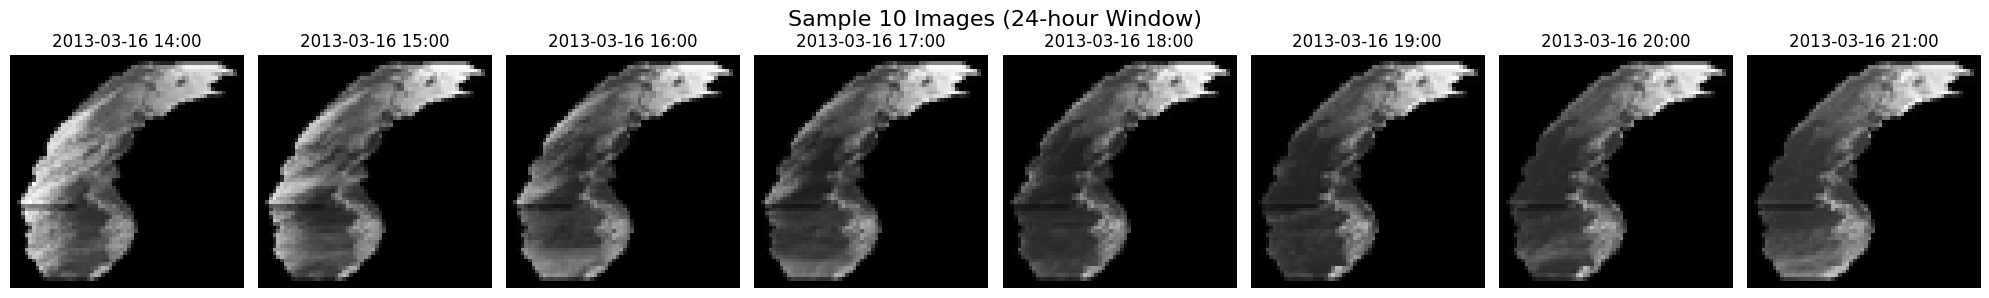


=== Sample 11 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,66.0,1036.8,12.0,3.0,1035.6,1012.3,5000.0,330.0,16.0,0.0
1,72.0,1037.6,11.0,4.0,1036.2,1012.9,4200.0,330.0,13.0,0.0
2,66.0,1038.1,11.0,2.0,1036.9,1013.6,3700.0,310.0,11.0,0.0
3,83.0,1033.0,4.0,-0.0,1031.5,1008.3,3000.0,0.0,0.0,10000.0
4,79.0,1032.5,7.0,2.0,1031.2,1008.0,11000.0,0.0,0.0,0.0
5,67.0,1032.2,16.0,7.0,1030.8,1007.6,11000.0,190.0,7.0,20000.0
6,62.0,1031.7,21.0,10.0,1030.5,1007.3,9500.0,190.0,8.0,20000.0
7,59.0,1030.8,24.0,12.0,1029.5,1006.3,9000.0,200.0,9.0,20000.0
8,52.0,1029.6,27.0,12.0,1028.4,1005.3,2300.0,0.0,6.0,8500.0
9,55.0,1028.9,29.0,15.0,1027.8,1004.6,2500.0,250.0,13.0,9000.0


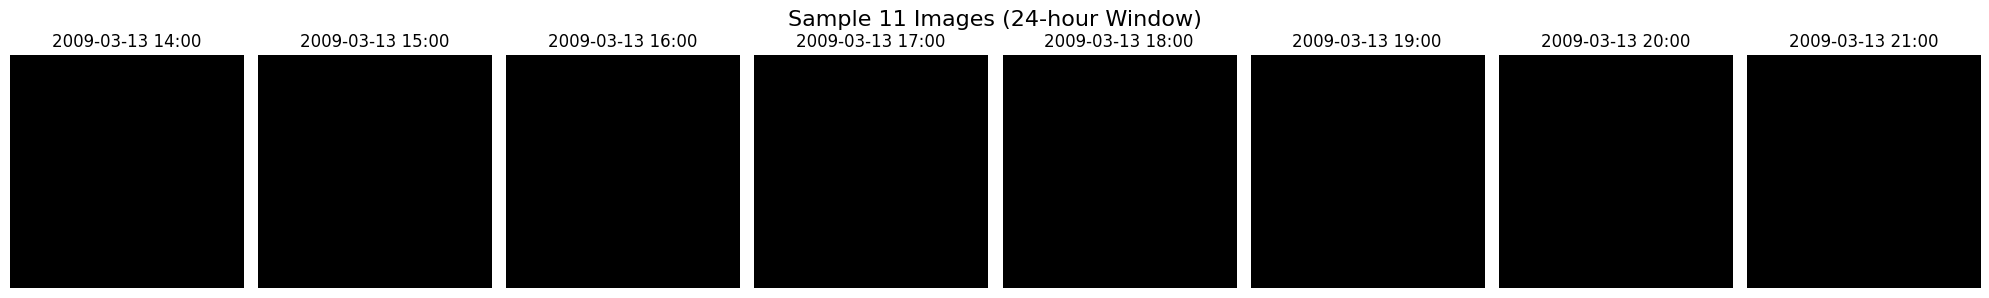


=== Sample 12 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,83.0,1021.5,10.0,6.0,1020.3,997.3,400.0,100.0,7.0,1300.0
1,73.0,1022.9,13.0,6.0,1021.7,998.7,1100.0,20.0,11.0,2000.0
2,69.0,1024.1,12.0,4.0,1022.7,999.6,1600.0,60.0,8.0,2200.0
3,80.0,1024.9,13.0,8.0,1023.4,1000.3,1600.0,70.0,9.0,2700.0
4,55.0,1025.1,15.0,2.0,1023.7,1000.6,2200.0,360.0,10.0,3400.0
5,58.0,1025.6,15.0,3.0,1024.4,1001.3,3500.0,20.0,13.0,4500.0
6,58.0,1025.9,16.0,4.0,1024.4,1001.3,3500.0,350.0,9.0,4400.0
7,72.0,0.0,16.0,9.0,1025.1,1002.0,1800.0,330.0,9.0,3000.0
8,70.0,1026.8,17.0,9.0,1025.4,1002.3,1800.0,330.0,7.0,2800.0
9,83.0,1027.5,15.0,11.0,1026.1,1003.0,800.0,290.0,3.0,1600.0


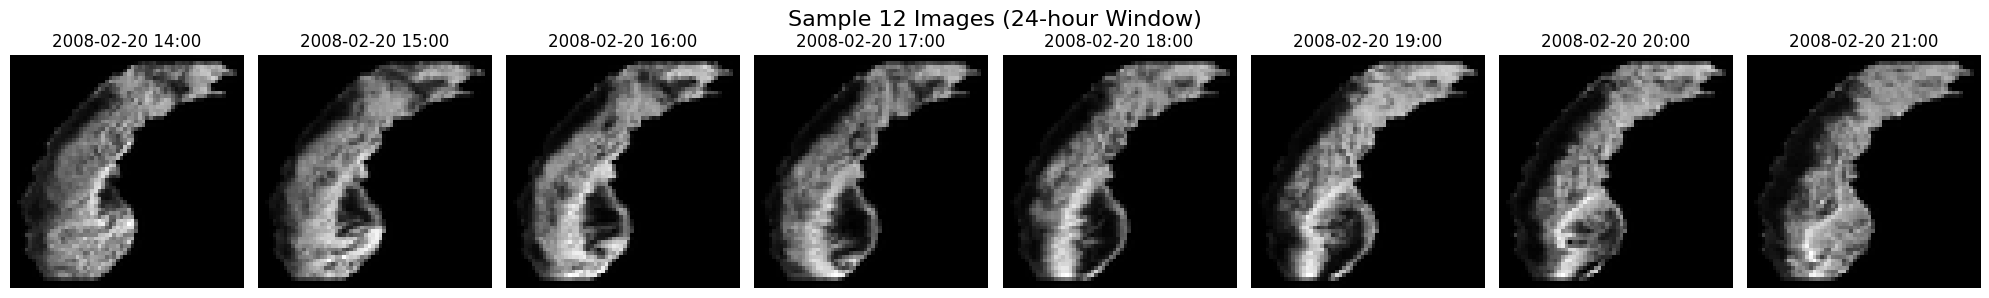


=== Sample 13 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,78.0,1010.4,32.0,26.0,1009.5,986.7,2500.0,250.0,6.0,3700.0
1,72.0,1010.8,32.0,24.0,1009.8,987.0,3700.0,270.0,14.0,4400.0
2,81.0,1011.8,30.0,25.0,1011.2,988.3,1500.0,330.0,8.0,2200.0
3,68.0,1012.1,30.0,21.0,1011.2,988.3,2200.0,330.0,11.0,2700.0
4,77.0,1019.2,23.0,17.0,1018.3,995.3,1400.0,180.0,5.0,0.0
5,77.0,1018.3,24.0,18.0,1017.3,994.3,1400.0,0.0,3.0,0.0
6,77.0,1017.6,24.0,18.0,1016.6,993.7,1400.0,0.0,6.0,0.0
7,77.0,1016.8,24.0,18.0,1015.9,993.0,1400.0,180.0,6.0,0.0
8,80.0,1015.6,24.0,19.0,1014.6,991.7,1300.0,170.0,6.0,0.0
9,80.0,1014.8,24.0,19.0,1013.9,991.0,1200.0,170.0,5.0,0.0


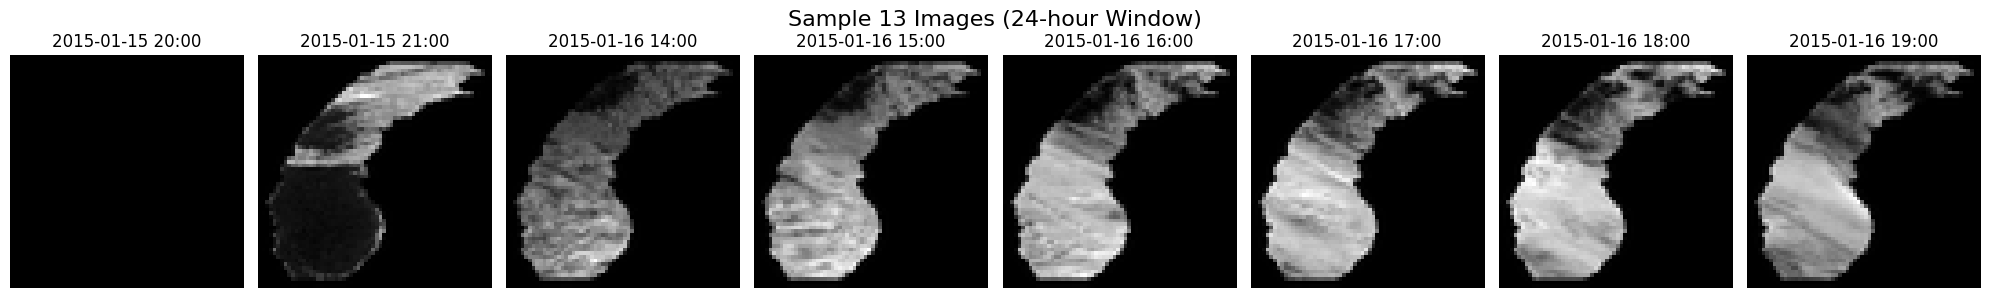


=== Sample 14 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,88.0,1020.2,29.0,26.0,1019.6,996.7,0.0,0.0,0.0,0.0
1,88.0,1020.9,28.0,25.0,1020.3,997.3,0.0,0.0,0.0,0.0
2,92.0,1021.2,26.0,24.0,1020.7,997.7,2000.0,0.0,0.0,0.0
3,88.0,1021.6,26.0,23.0,1021.0,998.0,2200.0,0.0,0.0,0.0
4,81.0,1018.6,36.0,31.0,1017.9,995.0,1200.0,0.0,7.0,2200.0
5,81.0,1017.9,36.0,31.0,1017.3,994.3,1400.0,130.0,9.0,2600.0
6,78.0,1017.2,37.0,31.0,1016.6,993.7,9500.0,120.0,7.0,20000.0
7,78.0,1016.1,37.0,31.0,1015.2,992.3,10000.0,120.0,6.0,0.0
8,72.0,1015.4,39.0,31.0,1014.6,991.7,10000.0,140.0,6.0,0.0
9,72.0,1014.1,39.0,31.0,1013.5,990.7,7500.0,120.0,11.0,9500.0


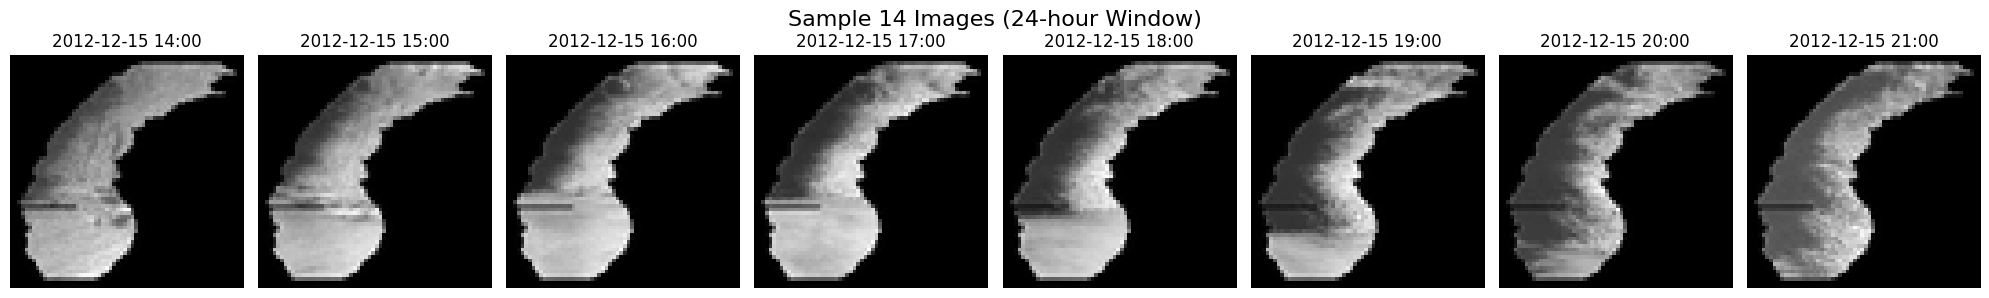


=== Sample 15 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,63.0,1005.0,34.0,23.0,1004.7,982.0,2600.0,250.0,16.0,0.0
1,77.0,1005.0,33.0,27.0,1004.7,982.0,2800.0,250.0,15.0,4500.0
2,84.0,1005.1,33.0,29.0,1004.7,982.0,1500.0,260.0,13.0,2300.0
3,69.0,1005.5,35.0,26.0,1005.1,982.4,3300.0,270.0,24.0,5000.0
4,69.0,1006.2,35.0,26.0,1005.8,983.0,2100.0,310.0,24.0,3500.0
5,74.0,0.0,34.0,27.0,1006.8,984.0,1900.0,290.0,23.0,3700.0
6,81.0,1008.4,32.0,27.0,1007.8,985.0,1400.0,300.0,20.0,0.0
7,63.0,1009.7,34.0,23.0,1009.1,986.4,2800.0,310.0,26.0,4000.0
8,71.0,1011.5,33.0,25.0,1010.8,988.0,2400.0,300.0,31.0,3300.0
9,69.0,1013.1,33.0,24.0,1012.5,989.7,2700.0,300.0,23.0,3500.0


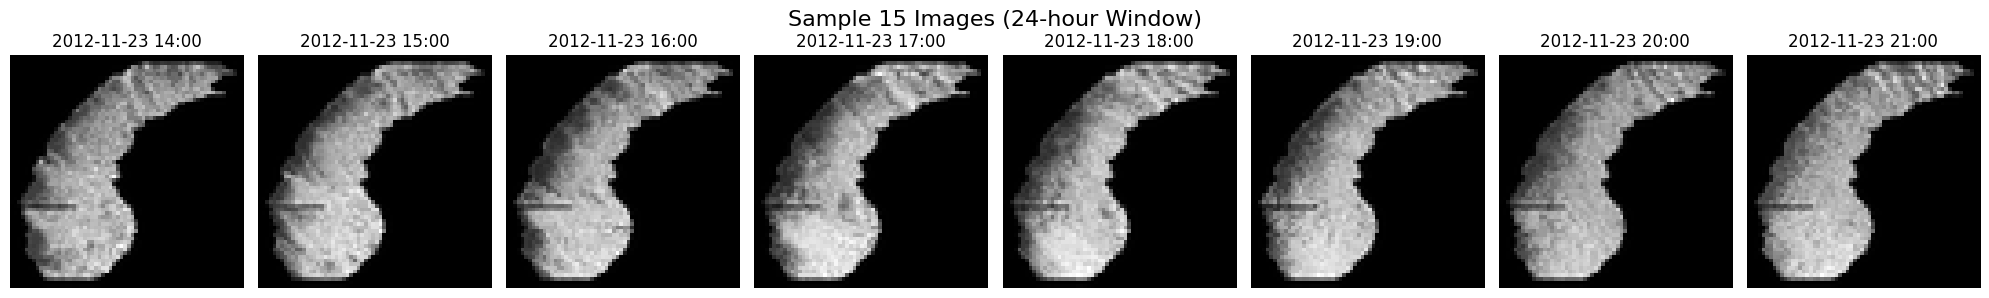


=== Sample 16 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,82.0,1009.2,40.0,35.0,1008.8,986.0,2800.0,280.0,10.0,3700.0
1,75.0,0.0,43.0,36.0,1009.1,986.4,3000.0,300.0,14.0,3800.0
2,75.0,1010.0,42.0,35.0,1009.5,986.7,2900.0,300.0,11.0,4100.0
3,62.0,1010.1,45.0,33.0,1009.5,986.7,3200.0,300.0,15.0,5000.0
4,54.0,1009.7,49.0,33.0,1009.1,986.4,3700.0,310.0,16.0,4600.0
5,55.0,1009.7,47.0,32.0,1009.1,986.4,3700.0,310.0,14.0,4900.0
6,60.0,1010.1,45.0,32.0,1009.8,987.0,4000.0,310.0,17.0,5500.0
7,70.0,1010.7,43.0,34.0,1010.5,987.7,2200.0,330.0,10.0,4000.0
8,72.0,1011.3,42.0,34.0,1010.8,988.0,3600.0,330.0,11.0,4400.0
9,85.0,1011.9,37.0,33.0,1011.5,988.7,1500.0,290.0,10.0,2600.0


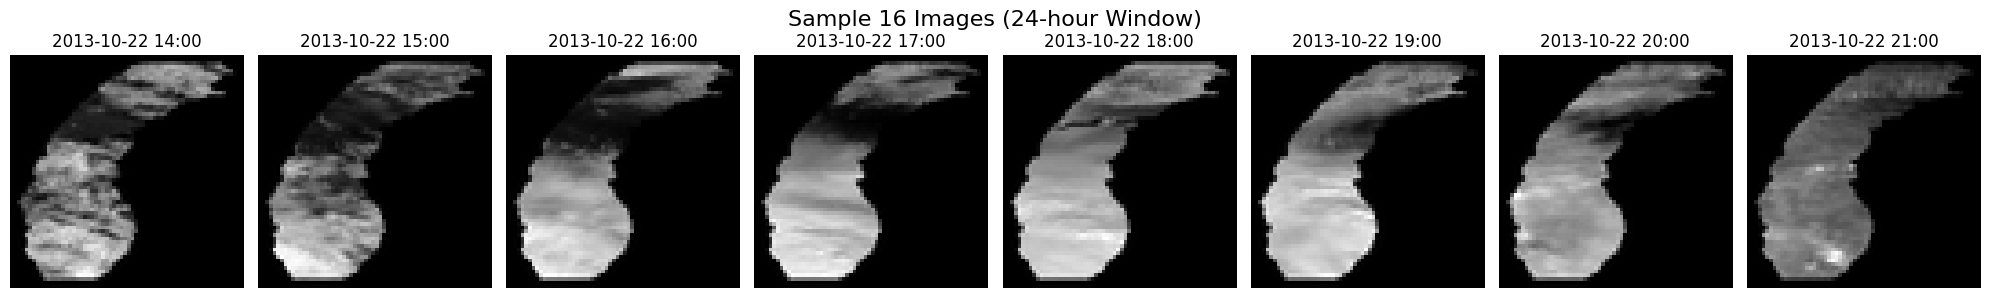


=== Sample 17 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,74.0,1013.3,59.0,51.0,1013.2,990.3,5000.0,0.0,0.0,0.0
1,86.0,1013.5,57.0,53.0,1013.5,990.7,3900.0,120.0,5.0,5000.0
2,89.0,1012.8,57.0,54.0,1012.5,989.7,1900.0,0.0,5.0,4700.0
3,86.0,1012.4,58.0,54.0,1012.2,989.3,5000.0,0.0,5.0,7000.0
4,93.0,1012.8,57.0,55.0,1012.5,989.7,1800.0,140.0,3.0,3300.0
5,90.0,1012.4,58.0,55.0,1012.2,989.3,1000.0,0.0,0.0,1400.0
6,93.0,1011.8,58.0,56.0,1011.9,989.0,1200.0,100.0,3.0,0.0
7,89.0,1010.5,60.0,57.0,1010.5,987.7,1300.0,110.0,6.0,2000.0
8,82.0,0.0,63.0,57.0,1010.2,987.3,1800.0,130.0,6.0,3100.0
9,86.0,1009.3,62.0,58.0,1009.5,986.7,1300.0,150.0,6.0,2000.0


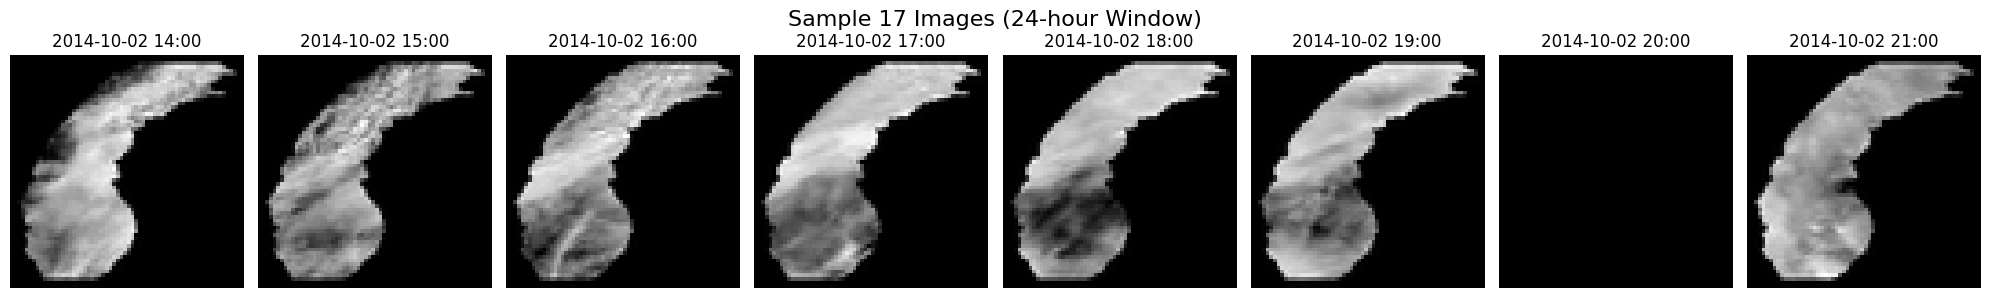


=== Sample 18 ===
Target (y): Class 1
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,82.0,1027.6,1.0,-3.0,1026.1,1003.0,2100.0,0.0,0.0,3100.0
1,83.0,1027.9,2.0,-2.0,1026.4,1003.3,3100.0,0.0,0.0,0.0
2,83.0,1027.5,2.0,-2.0,1026.1,1003.0,3100.0,0.0,0.0,0.0
3,83.0,1027.1,3.0,-1.0,1025.7,1002.6,3300.0,0.0,0.0,0.0
4,73.0,1017.5,19.0,12.0,1016.6,993.7,3600.0,360.0,10.0,0.0
5,79.0,0.0,18.0,12.0,1017.3,994.3,1800.0,350.0,10.0,2400.0
6,73.0,1019.2,17.0,10.0,1018.3,995.3,1900.0,300.0,10.0,3800.0
7,76.0,1019.6,16.0,10.0,1018.6,995.7,2600.0,270.0,8.0,3800.0
8,78.0,0.0,16.0,10.0,1019.3,996.3,2100.0,300.0,8.0,3400.0
9,76.0,1021.7,15.0,9.0,1020.7,997.7,5000.0,280.0,10.0,0.0


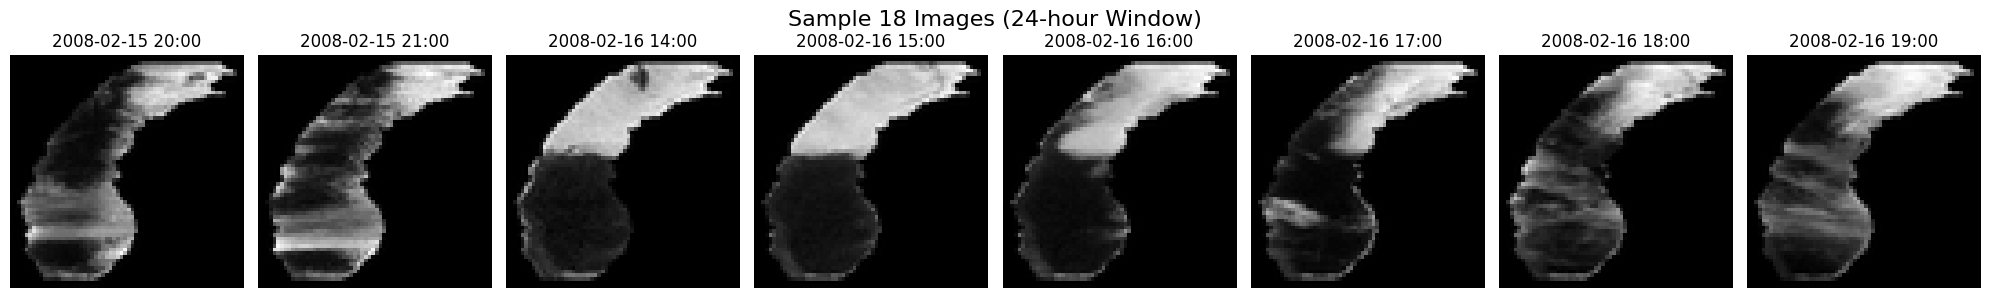


=== Sample 19 ===
Target (y): Class 2
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,62.0,1030.9,28.0,17.0,1030.1,1007.0,2300.0,340.0,5.0,0.0
1,71.0,1031.0,27.0,19.0,1030.1,1007.0,2300.0,70.0,5.0,0.0
2,68.0,1030.8,27.0,18.0,1029.8,1006.6,2300.0,0.0,0.0,0.0
3,74.0,1031.1,23.0,16.0,1030.1,1007.0,2100.0,80.0,3.0,0.0
4,78.0,1025.3,29.0,23.0,1024.7,1001.6,1700.0,360.0,10.0,0.0
5,74.0,1025.7,28.0,21.0,1025.1,1002.0,1900.0,350.0,10.0,0.0
6,74.0,1025.8,28.0,21.0,1025.1,1002.0,2000.0,360.0,6.0,0.0
7,74.0,1026.0,28.0,21.0,1025.4,1002.3,1600.0,360.0,8.0,0.0
8,73.0,0.0,27.0,19.0,1025.7,1002.6,1800.0,350.0,7.0,3400.0
9,71.0,1026.6,28.0,20.0,1025.7,1002.6,2400.0,350.0,5.0,0.0


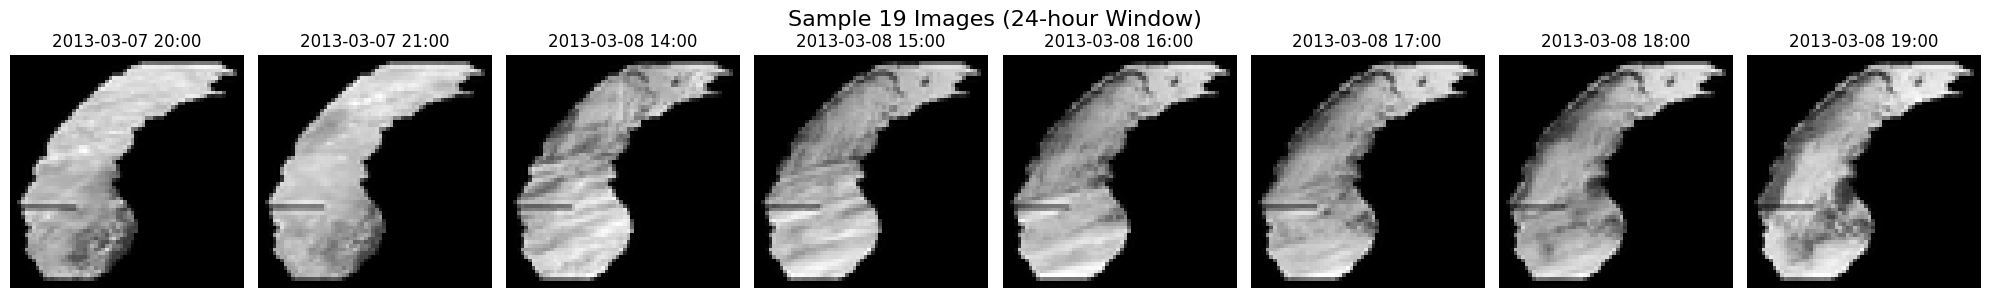


=== Sample 20 ===
Target (y): Class 3
Meteorological Data:


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,82.0,1017.9,45.0,40.0,1017.6,994.7,1200.0,110.0,8.0,0.0
1,82.0,1017.4,45.0,40.0,1016.9,994.0,1000.0,80.0,5.0,0.0
2,82.0,1017.3,45.0,40.0,1016.9,994.0,900.0,110.0,5.0,0.0
3,82.0,1016.6,45.0,40.0,1016.3,993.3,800.0,110.0,6.0,0.0
4,85.0,1015.8,44.0,40.0,1015.6,992.7,700.0,90.0,11.0,0.0
5,88.0,1015.2,44.0,41.0,1014.9,992.0,700.0,90.0,6.0,0.0
6,89.0,994.0,57.0,54.0,993.9,971.4,4400.0,0.0,5.0,5500.0
7,89.0,992.5,57.0,54.0,992.6,970.1,4000.0,130.0,7.0,4900.0
8,86.0,991.2,57.0,53.0,991.2,968.7,5500.0,140.0,8.0,7000.0
9,86.0,990.0,57.0,53.0,990.2,967.7,2400.0,130.0,7.0,5500.0


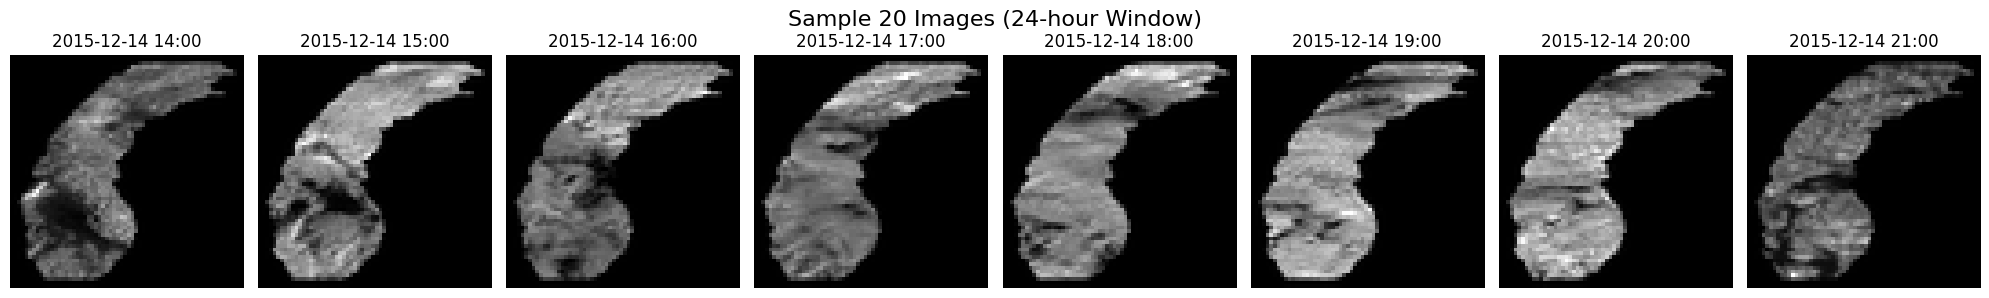

In [14]:
# Display the first 20 samples for the 24-hour window
display_first_n_samples(reduced_data_filtered_all, window_size=24, num_samples=20)

In [15]:
# Verify the reduced data shapes
print(f"Reduced 24-hour Training: {reduced_data_filtered_all[24]['X_train_meteo'].shape}")
print(f"Reduced 24-hour Validation: {reduced_data_filtered_all[24]['X_val_meteo'].shape}")
print(f"Reduced 48-hour Training: {reduced_data_filtered_all[48]['X_train_meteo'].shape}")
print(f"Reduced 48-hour Validation: {reduced_data_filtered_all[48]['X_val_meteo'].shape}")
print(f"Reduced 72-hour Training: {reduced_data_filtered_all[72]['X_train_meteo'].shape}")
print(f"Reduced 72-hour Validation: {reduced_data_filtered_all[72]['X_val_meteo'].shape}")

Reduced 24-hour Training: (31253, 24, 10)
Reduced 24-hour Validation: (504, 24, 10)
Reduced 48-hour Training: (31196, 48, 10)
Reduced 48-hour Validation: (504, 48, 10)
Reduced 72-hour Training: (31138, 72, 10)
Reduced 72-hour Validation: (504, 72, 10)


In [16]:
X_train_24, y_train_24 = reduced_data_filtered_all[24]['X_train_meteo'], reduced_data_filtered_all[24]['y_train']
X_val_24, y_val_24 = reduced_data_filtered_all[24]['X_val_meteo'], reduced_data_filtered_all[24]['y_val']
# Extract image data
X_train_images_24 = reduced_data_filtered_all[24]['X_train_images']
X_val_images_24 = reduced_data_filtered_all[24]['X_val_images']

X_train_48, y_train_48 = reduced_data_filtered_all[48]['X_train_meteo'], reduced_data_filtered_all[48]['y_train']
X_val_48, y_val_48 = reduced_data_filtered_all[48]['X_val_meteo'], reduced_data_filtered_all[48]['y_val']
X_train_images_48 = reduced_data_filtered_all[48]['X_train_images']
X_val_images_48 = reduced_data_filtered_all[48]['X_val_images']

X_train_72, y_train_72 = reduced_data_filtered_all[72]['X_train_meteo'], reduced_data_filtered_all[72]['y_train']
X_val_72, y_val_72 = reduced_data_filtered_all[72]['X_val_meteo'], reduced_data_filtered_all[72]['y_val']
X_train_images_72 = reduced_data_filtered_all[72]['X_train_images']
X_val_images_72 = reduced_data_filtered_all[72]['X_val_images']

## 6. Saving the Data

Now, let's save the data for the final inference notebook.

In [17]:
# Directory to store pickle files
data_dir = "processed_data_pickles"
os.makedirs(data_dir, exist_ok=True)

# Save datasets for 24-hour, 48-hour, and 72-hour windows
datasets = {
    '24': (X_train_24, y_train_24, X_val_24, y_val_24, X_train_images_24, X_val_images_24),
    '48': (X_train_48, y_train_48, X_val_48, y_val_48, X_train_images_48, X_val_images_48),
    '72': (X_train_72, y_train_72, X_val_72, y_val_72, X_train_images_72, X_val_images_72)
}

for window_size, data in datasets.items():
    file_path = os.path.join(data_dir, f"data_{window_size}_hour.pkl")
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved {window_size}-hour dataset to {file_path}")

Saved 24-hour dataset to processed_data_pickles/data_24_hour.pkl
Saved 48-hour dataset to processed_data_pickles/data_48_hour.pkl
Saved 72-hour dataset to processed_data_pickles/data_72_hour.pkl
